# Energy conservation

**Different options**
1. "Culprit" variable
2. Additive correction
3. Multiplicative correction (doesn't seem to fit)
4. After-the-fact post-processing (not tried yet)

**Radiation**

- vint(QRL)\*C_P + vint(QRS)\*C_P = FSNT - FSNS - FLNT - FLNS

**MSE**

- vint(TPHYSTND_NORAD)\*C_P + vint(PHQ)\*L_S + vint(PHCLDICE)\*L_I = vint(DTV)\*C_P + vint(VD01)\*L_S + dPREC
- dPREC = (PRECSC + PRECSL)\*1e3 + PRECSTEN - (PRECT\*1e3 + PRECTEND))\*L_I

**Moisture**

- PRECT + PRECTEND\*1e-3 = vint(SPDQ) + vint(SPDCQ) + vint(SPDQI) = vint(PHQ) - vint(VD01) + vint(PHCLDLIQ) + vint(PHCLDICE)

**ToDo**

1. Test post-processing option for radiation and compare the 4 options
1. Do the same for MSE
1. Then the same for moisture
1. Clean up and combine all of the options
1. Test again before implementation in scripts

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline
from cbrain.imports import *
from cbrain.utils import *
from keras.layers import *
from keras import backend as K
from keras.engine.topology import Layer
import tensorflow as tf
limit_mem()
import matplotlib as mpl

/home1/05488/tg847872/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
def concat_ds(ds, vars, fact=None):
    arr = []
    for i, v in enumerate(vars):
        da = ds[v].values.copy()
        if fact is not None: da *= fact[i]
        arr.append(np.expand_dims(da, 1) if da.ndim==3 else da)
    arr = np.concatenate(arr, 1)
    return np.rollaxis(arr, 1, 4).reshape(-1, arr.shape[1])

In [ ]:
dt = 1800

In [ ]:
ngeo = 64*128
def split(f, t, nt=40):
    return f[:nt*ngeo], f[nt*ngeo:], t[:nt*ngeo], t[nt*ngeo:]

In [ ]:
# Auto-complete shortcuts :)
TPHYSTND, PHQ, PHCLDICE, PHCLDLIQ, TOT_PRECL, TOT_PRECS, FSNT, FSNS, FLNT, FLNS = \
'TPHYSTND', 'PHQ', 'PHCLDICE', 'PHCLDLIQ', 'TOT_PRECL', 'TOT_PRECS', 'FSNT', 'FSNS', 'FLNT', 'FLNS'
TBP, QBP, QCBP, QIBP, PS, SOLIN, SHFLX, LHFLX = 'TBP', 'QBP', 'QCBP', 'QIBP', 'PS', 'SOLIN', 'SHFLX', 'LHFLX'
SHFLX_PRE, LHFLX_PRE = 'SHFLX_PRE', 'LHFLX_PRE'
TPHY_NOKE = 'TPHY_NOKE'

## Change output conversion for full experiments

In [7]:
normfn = '/scratch/srasp/preprocessed_data/fbp32_engy_cons_train_sample1_norm.nc'
!mv {normfn} {normfn}.orig

In [8]:
norm = xr.open_dataset(f'{normfn}.orig')

In [9]:
norm

<xarray.Dataset>
Dimensions:              (feature_lev: 154, target_lev: 126)
Coordinates:
  * feature_lev          (feature_lev) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 ...
  * target_lev           (target_lev) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 ...
Data variables:
    feature_means        (feature_lev) float32 ...
    feature_stds         (feature_lev) float32 ...
    feature_mins         (feature_lev) float32 ...
    feature_maxs         (feature_lev) float32 ...
    target_means         (target_lev) float32 ...
    target_stds          (target_lev) float32 ...
    target_mins          (target_lev) float32 ...
    target_maxs          (target_lev) float32 ...
    feature_names        (feature_lev) object ...
    target_names         (target_lev) object ...
    feature_stds_by_var  (feature_lev) float32 ...
    target_conv          (target_lev) float32 ...
Attributes:
    log:      \n    Time: 2018-04-10T10:43:31\n\n    Executed command:\n\n   ...

In [10]:
norm['target_conv']

<xarray.DataArray 'target_conv' (target_lev: 126)>
array([1.00e+03, 1.00e+03, 1.00e+03, 1.00e+03, 1.00e+03, 1.00e+03, 1.00e+03,
       1.00e+03, 1.00e+03, 1.00e+03, 1.00e+03, 1.00e+03, 1.00e+03, 1.00e+03,
       1.00e+03, 1.00e+03, 1.00e+03, 1.00e+03, 1.00e+03, 1.00e+03, 1.00e+03,
       1.00e+03, 1.00e+03, 1.00e+03, 1.00e+03, 1.00e+03, 1.00e+03, 1.00e+03,
       1.00e+03, 1.00e+03, 2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06,
       2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06,
       2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06,
       2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06,
       2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06,
       2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06,
       2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06,
       2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06, 2.50e+06,
       2.50e+06, 2.50e+06

In [11]:
norm['target_conv_v2'] = norm['target_conv'].copy()

In [410]:
#outpfacts = [C_P, L_S, L_S, L_S, 24*3600*2e-2, 24*3600*2e-2, 1e-3, -1e-3, -1e-3, 1e-3]

In [12]:
norm['target_conv_v2'][30:120] = L_S

In [13]:
norm['target_conv_v2'][-6:] = [24*3600*2e-2, 24*3600*2e-2, 1e-3, -1e-3, -1e-3, 1e-3]

In [14]:
norm['target_conv_v2']

<xarray.DataArray 'target_conv_v2' (target_lev: 126)>
array([ 1.0000e+03,  1.0000e+03,  1.0000e+03,  1.0000e+03,  1.0000e+03,
        1.0000e+03,  1.0000e+03,  1.0000e+03,  1.0000e+03,  1.0000e+03,
        1.0000e+03,  1.0000e+03,  1.0000e+03,  1.0000e+03,  1.0000e+03,
        1.0000e+03,  1.0000e+03,  1.0000e+03,  1.0000e+03,  1.0000e+03,
        1.0000e+03,  1.0000e+03,  1.0000e+03,  1.0000e+03,  1.0000e+03,
        1.0000e+03,  1.0000e+03,  1.0000e+03,  1.0000e+03,  1.0000e+03,
        2.8347e+06,  2.8347e+06,  2.8347e+06,  2.8347e+06,  2.8347e+06,
        2.8347e+06,  2.8347e+06,  2.8347e+06,  2.8347e+06,  2.8347e+06,
        2.8347e+06,  2.8347e+06,  2.8347e+06,  2.8347e+06,  2.8347e+06,
        2.8347e+06,  2.8347e+06,  2.8347e+06,  2.8347e+06,  2.8347e+06,
        2.8347e+06,  2.8347e+06,  2.8347e+06,  2.8347e+06,  2.8347e+06,
        2.8347e+06,  2.8347e+06,  2.8347e+06,  2.8347e+06,  2.8347e+06,
        2.8347e+06,  2.8347e+06,  2.8347e+06,  2.8347e+06,  2.8347e+06,
        2.

In [15]:
norm.to_netcdf(normfn)

## Full conservation

In [56]:
# Load the data
DATA_DIR = '/scratch/srasp/fluxbypass_aqua/'
n_days = 5
ds = xr.open_mfdataset(
    f'{DATA_DIR}AndKua_aqua_SPCAM3.0_*.h1.0000-01-0[2-{1+n_days}]*',
    decode_times=False, decode_cf=False)

In [57]:
ds

<xarray.Dataset>
Dimensions:       (chars: 8, crm_x: 8, crm_y: 1, crm_z: 28, ilev: 31, isccp_prs: 7, isccp_prstau: 49, isccp_tau: 7, lat: 64, lev: 30, lon: 128, tbnd: 2, time: 240)
Coordinates:
  * lat           (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 ...
  * lon           (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 16.88 ...
  * crm_x         (crm_x) float64 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0
  * crm_y         (crm_y) float64 0.0
  * crm_z         (crm_z) float64 992.6 976.3 957.5 936.2 912.6 887.0 859.5 ...
  * lev           (lev) float64 3.643 7.595 14.36 24.61 38.27 54.6 72.01 ...
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 30.67 45.87 63.32 ...
  * isccp_prs     (isccp_prs) float64 90.0 245.0 375.0 500.0 620.0 740.0 900.0
  * isccp_tau     (isccp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 219.5
  * isccp_prstau  (isccp_prstau) float64 90.0 90.0 90.0 90.01 90.02 90.04 ...
  * time          (time) float64 1.0 1.021 1.042 1.062 1.083 1.104 1.125 ...
Di

In [58]:
ds[SHFLX_PRE] = ds[SHFLX]; ds[LHFLX_PRE] = ds[LHFLX]

In [59]:
ds[SHFLX_PRE].load(); ds[LHFLX_PRE].load();

In [60]:
ds[SHFLX_PRE][1:] = ds[SHFLX][:-1].values
ds[LHFLX_PRE][1:] = ds[LHFLX][:-1].values

In [61]:
ds = ds.isel(time=slice(1, None))

In [62]:
ds['TOT_PRECL'] = ds.PRECT * 1e3 + ds.PRECTEND
ds['TOT_PRECS'] = (ds.PRECSC + ds.PRECSL) * 1e3 + ds.PRECSTEN

In [63]:
ds[TPHY_NOKE] = ds.TPHYSTND - ds.DTVKE / dt

### MSE and Radiation combined
- Inputs: ['TBP', 'QBP', 'QCBP', 'QIBP', 'DTV', 'VD01', 'PS'] --> Normalized with max(std, eps)
- Outputs: [TPHYSTND_NORAD\*C_P, PHQ\*L_S, PHCLDLIQ\*L_S, PHCLDICE\*L_S, TOT_PRECL$*24*3600*1e-2$, TOT_PRECS$*24*3600*1e-2$]
- TOT_PRECL = (PRECT\*1e3 + PRECTEND)
- TOT_PRECS = (PRECSC + PRECSL)\*1e3 + PRECSTEN
- dturb = vint(ds, 'DTV', C_P) + vint(ds, 'VD01', L_S)
- dconv = vint(ds, 'TPHYSTND_NORAD', C_P) + vint(ds, 'PHQ', L_S) + vint(ds, 'PHCLDLIQ', L_I)
- dprec = ((ds.PRECSC + ds.PRECSL)*1e3 + ds.PRECSTEN - (ds.PRECT*1e3 + ds.PRECTEND))*L_I

In [263]:
dMSE = vint(ds, 'TPHY_NOKE', C_P) + vint(ds, 'PHQ', L_S) + vint(ds, 'PHCLDLIQ', L_I)

In [264]:
dRADFLX = ds.FSNT - ds.FSNS - ds.FLNT + ds.FLNS

In [265]:
dSRFFLX = ds.SHFLX + ds.LHFLX/L_V*L_S

In [266]:
dPREC = (ds.TOT_PRECS - ds.TOT_PRECL) * L_I

In [267]:
a = dMSE.isel(time=1).values

In [268]:
b = dRADFLX.isel(time=1).values + dSRFFLX.isel(time=0).values + dPREC.isel(time=1).values

In [269]:
diff = a-b

In [270]:
rel_diff = diff/(a+b)*2.

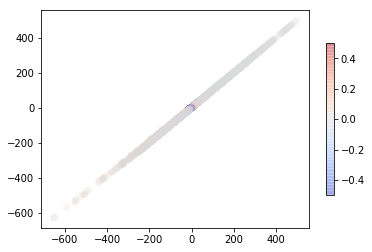

In [271]:
plt.scatter(a.flat, b.flat, c=rel_diff.flat, cmap='coolwarm', norm=mpl.colors.Normalize(vmin=-0.5,vmax=0.5), alpha=0.2);
plt.colorbar(shrink=0.7);

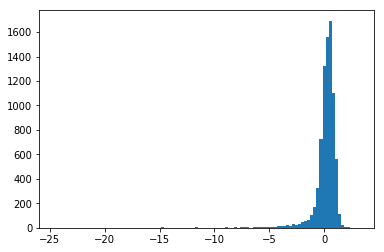

In [272]:
plt.hist(diff.flat, bins=100);

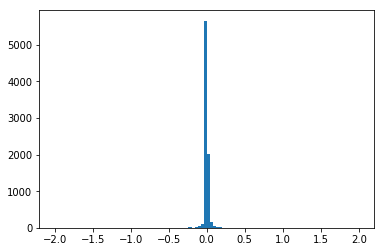

In [273]:
plt.hist(rel_diff.flat, bins=100, range=(-2, 2));

### Moisture conservation

In [274]:
dQCONV = vint(ds, 'PHQ', 1) + vint(ds, 'PHCLDLIQ', 1) + vint(ds, 'PHCLDICE', 1)

In [275]:
dQSRF = ds.LHFLX / L_V

In [276]:
dQPREC = ds.TOT_PRECL

In [277]:
a = dQCONV.isel(time=1).values

In [278]:
b = dQSRF.isel(time=0).values - dQPREC.isel(time=1).values

In [279]:
diff = a-b

In [280]:
rel_diff = diff/(a+b)*2.

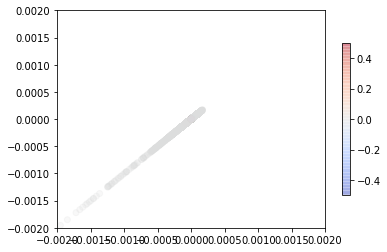

In [281]:
plt.scatter(a.flat, b.flat, c=rel_diff.flat, cmap='coolwarm', norm=mpl.colors.Normalize(vmin=-0.5,vmax=0.5), alpha=0.2);
plt.colorbar(shrink=0.7); plt.xlim(-2e-3, 2e-3); plt.ylim(-2e-3, 2e-3);

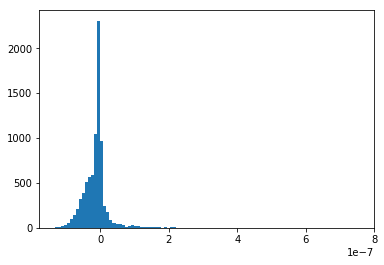

In [282]:
plt.hist(diff.flat, bins=100);

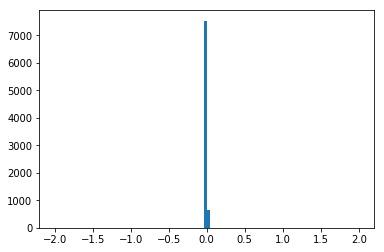

In [283]:
plt.hist(rel_diff.flat, bins=100, range=(-2, 2));

### Prepare the data

In [64]:
ds['TBP'] = ds['TAP'] - ds['TPHYSTND']*dt
ds['QBP'] = ds['QAP'] - ds['PHQ']*dt
ds['QCBP'] = ds['QCAP'] - ds['PHCLDLIQ']*dt
ds['QIBP'] = ds['QIAP'] - ds['PHCLDICE']*dt

In [65]:
inpvars = [TBP, QBP, QCBP, QIBP, PS, SOLIN, SHFLX_PRE, LHFLX_PRE]
outpvars = [TPHY_NOKE, PHQ, PHCLDLIQ, PHCLDICE, TOT_PRECL, TOT_PRECS, FSNT, FSNS, FLNT, FLNS]

In [66]:
# According to my December thinking the factor for precip should be 1e3*24*3600 * 1e-3
# The 1e3 was already done above
# But then it's pretty small and I want it to be weighted quite a lot
outpfacts = [C_P, L_S, L_S, L_S, 24*3600*2e-2, 24*3600*2e-2, 1e-3, -1e-3, -1e-3, 1e-3]

In [100]:
f = concat_ds(ds, inpvars)

In [68]:
t = concat_ds(ds, outpvars, outpfacts)

In [101]:
# Normalize features
fmeans = f.mean(0)
fstds = np.maximum(f.std(0), 1e-8)

In [102]:
frange = np.maximum(f.max(0)-f.min(0), 1e-8)

In [368]:
fstd_by_var = np.concatenate([
    [f[:, :30].std()]*30 + [f[:, 30:60].std()]*30 + [f[:, 60:90].std()]*30 + [f[:, 90:120].std()]*30, fstds[-4:]
])

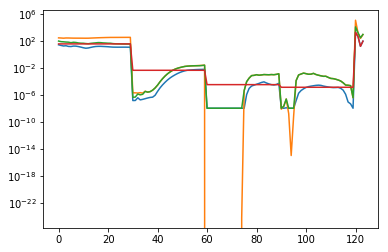

In [369]:
plt.plot(fstds); plt.plot(f.max(0)); plt.plot(frange); plt.plot(fstd_by_var); plt.yscale('log');

In [104]:
norm = lambda x: (x - fmeans) / frange
denorm = lambda x: x * frange + fmeans

In [105]:
fnorm = norm(f)

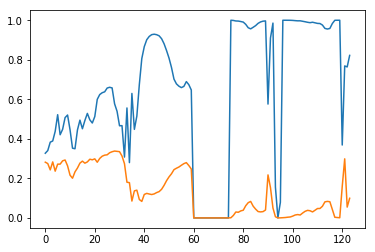

In [106]:
plt.plot(np.max(fnorm,0));plt.plot(fnorm.std(0))

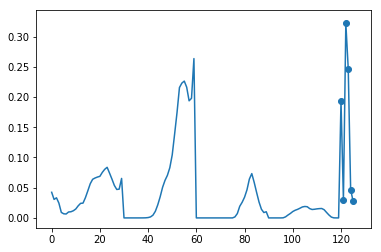

In [74]:
plt.plot(t.std(0)); plt.scatter(range(120, 126), t.std(0)[-6:])

In [245]:
x_trn, x_val, y_trn, y_val = split(fnorm, t, -48)
x_trn.shape, y_trn.shape

((1564672, 124), (1564672, 126))

### Reference network

In [108]:
inp = Input(shape=(x_trn.shape[1],))
x = LeakyReLU()(Dense(512)(inp))
x = LeakyReLU()(Dense(512)(x))
outp = Dense(y_trn.shape[1])(x)
net = keras.models.Model(inp, outp)

In [109]:
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 124)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               64000     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 126)               64638     
Total params: 391,294
Trainable params: 391,294
Non-trainable params: 0
_________________________________________________________________


In [110]:
net.compile('adam', 'mse')

#### Training

In [111]:
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 1564672 samples, validate on 393216 samples
Epoch 1/10
1564672/1564672 [==============================] - 19s 12us/step - loss: 0.0032 - val_loss: 0.0029
Epoch 2/10
1564672/1564672 [==============================] - 19s 12us/step - loss: 0.0029 - val_loss: 0.0029
Epoch 3/10
1564672/1564672 [==============================] - 19s 12us/step - loss: 0.0028 - val_loss: 0.0027
Epoch 4/10
1564672/1564672 [==============================] - 20s 12us/step - loss: 0.0028 - val_loss: 0.0026
Epoch 5/10
1564672/1564672 [==============================] - 19s 12us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 6/10
1564672/1564672 [==============================] - 19s 12us/step - loss: 0.0027 - val_loss: 0.0026
Epoch 7/10
1564672/1564672 [==============================] - 19s 12us/step - loss: 0.0027 - val_loss: 0.0026
Epoch 8/10
1564672/1564672 [==============================] - 19s 12us/step - loss: 0.0027 - val_loss: 0.0026
Epoch 9/10
1564672/1564672 [==============================] - 19s 1

In [112]:
net.optimizer.lr = 1e-4

In [113]:
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 1564672 samples, validate on 393216 samples
Epoch 1/10
1564672/1564672 [==============================] - 19s 12us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 2/10
1564672/1564672 [==============================] - 19s 12us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 3/10
1564672/1564672 [==============================] - 19s 12us/step - loss: 0.0026 - val_loss: 0.0025
Epoch 4/10
1564672/1564672 [==============================] - 19s 12us/step - loss: 0.0026 - val_loss: 0.0025
Epoch 5/10
1564672/1564672 [==============================] - 19s 12us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 6/10
1564672/1564672 [==============================] - 19s 12us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 7/10
1564672/1564672 [==============================] - 19s 12us/step - loss: 0.0026 - val_loss: 0.0025
Epoch 8/10
1564672/1564672 [==============================] - 19s 12us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 9/10
1564672/1564672 [==============================] - 19s 1

In [114]:
net.optimizer.lr = 1e-5
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 1564672 samples, validate on 393216 samples
Epoch 1/10
1075200/1564672 [===================>..........] - ETA: 5s - loss: 0.0026

KeyboardInterrupt: 

#### Evaluation

In [125]:
raw = net.predict(x_val, 4096)

In [183]:
def get_dQ(x, y):
    PS = x[:, 120] * frange[120] + fmeans[120]
    P = P0 * hyai + PS[:, None] * hybi
    dP = P[:, 1:] - P[:, :-1]
    vintPHQ = np.sum(y[:, 30:60]*dP/G, 1) / L_S
    vintPHCLDLIQ = np.sum(y[:, 60:90]*dP/G, 1) / L_S
    vintPHCLDICE = np.sum(y[:, 90:120]*dP/G, 1) / L_S
    dQCONV = vintPHQ + vintPHCLDLIQ + vintPHCLDICE
    LHFLX = x[:, 123] * frange[123] + fmeans[123]
    dQSRF = LHFLX / L_V
    dQPREC = y[:, 120] / (24*3600*2e-2)  # TOT_PRECL
    dQ = dQCONV - dQSRF + dQPREC
    return dQCONV, dQSRF - dQPREC, dQ

In [184]:
def get_dE(x, y):
    PS = x[:, 120] * frange[120] + fmeans[120]
    P = P0 * hyai + PS[:, None] * hybi
    dP = P[:, 1:] - P[:, :-1]
    vintTPHY = np.sum(y[:, :30]*dP/G, 1)
    vintPHQ = np.sum(y[:, 30:60]*dP/G, 1)
    vintPHCLDLIQ = np.sum(y[:, 60:90]*dP/G, 1) / L_S * L_I
    dMSE = vintTPHY + vintPHQ + vintPHCLDLIQ
    dRADFLX = np.sum(y[:, -4:], 1) * 1e3
    SHFLX = x[:, 122] * frange[122] + fmeans[122]
    LHFLX = x[:, 123] * frange[123] + fmeans[123]
    dSRFFLX = SHFLX + LHFLX/L_V*L_S
    TOT_PRECL = y[:, 120] / (24*3600*2e-2)
    TOT_PRECS = y[:, 121] / (24*3600*2e-2)
    dPREC = (TOT_PRECS - TOT_PRECL) * L_I
    dE = dMSE - dRADFLX - dSRFFLX - dPREC
    return dMSE, dRADFLX + dSRFFLX + dPREC, dE

In [311]:
def check_preds(m, s='val', preds=None, n=None):
    x, y = (x_val, y_val) if s == 'val' else (x_trn, y_trn)
    preds = m.predict(x, batch_size=1024) if preds is None else preds
    if preds.shape[0] != x.shape[0]:
        x = x[:preds.shape[0]]; y = y[:preds.shape[0]]
    if n is not None:
        x, y, preds = x[:n], y[:n], preds[:n]
    dQ1, dQ2, dQ = get_dQ(x, preds)
    dE1, dE2, dE = get_dE(x, preds)
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))
    for ax in axes.flat:
        idx = np.random.randint(0, x.shape[0])
        ax.plot(y[idx]); ax.plot(preds[idx])
        ax.set_title(f'idx = {idx}')
        ax.axhline(0, zorder=0.1, c='gray')
    plt.show()
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))
    axes[0].scatter(dQ1, dQ2)
    axes[0].set_title(f'mean(dQ) = {np.abs(dQ1-dQ2).mean()}') 
    axes[0].set_xlim(-4e-3, 1e-3); axes[0].set_ylim(-4e-3, 1e-3);
    axes[1].scatter(dE1, dE2)
    axes[1].set_title(f'mean(dE) = {np.abs(dE1-dE2).mean()}')
    mse = np.mean((preds - y)**2, 0); var = np.var(y, 0)
    r2 = 1 - (mse/var)
    axes[2].plot(r2); axes[2].scatter(range(120, 126), r2[-6:])
    axes[2].set_ylim(0,1); axes[2].set_xlim(0, r2.size)
    axes[2].set_title(f'r2 = {np.nanmean(r2[var>1e-6])}')

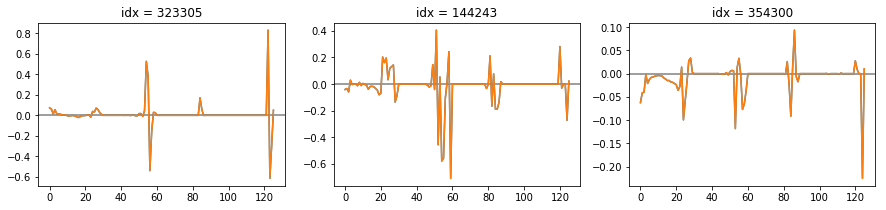

/export/home/srasp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


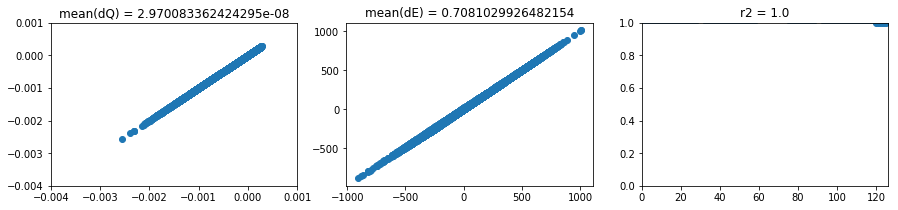

In [248]:
check_preds(None, preds=y_val)

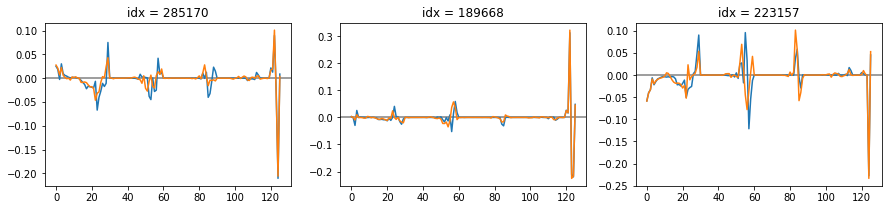

/export/home/srasp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


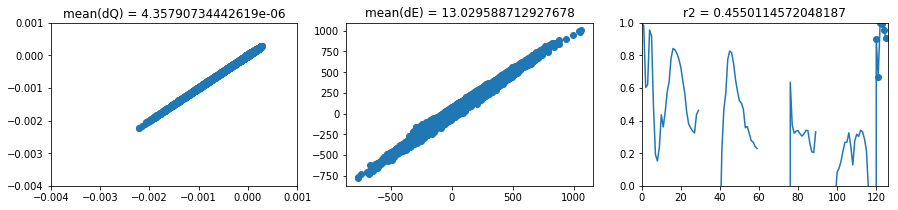

In [270]:
check_preds(net)

### Conservation

#### Post processing

In [255]:
def np_Q_layer(arrs):
    """
    """
    x, a = arrs[0].copy(), arrs[1].copy()
    # Get pressure difference 
    PS = x[:, 120] * frange[120] + fmeans[120]
    P = P0 * hyai + PS[:, None] * hybi
    dP = P[:, 1:] - P[:, :-1]
    
    # Get Convective integrals
    iPHQ, iPHCLDLIQ, iPHCLDICE = a[:, 30:60]*dP/G/L_S, a[:, 60:90]*dP/G/L_S, a[:, 90:120]*dP/G/L_S
    vPHQ, vPHCLDLIQ, vPHCLDICE = iPHQ.sum(1), iPHCLDLIQ.sum(1), iPHCLDICE.sum(1)
    absvPHQ, absvPHCLDLIQ, absvPHCLDICE = np.abs(iPHQ).sum(1), np.abs(iPHCLDLIQ).sum(1), np.abs(iPHCLDICE).sum(1)
    # Sum for convective moisture
    dQCONV = vPHQ + vPHCLDLIQ + vPHCLDICE
    
    # Get surface flux
    LHFLX = (x[:, 123] * frange[123] + fmeans[123]) / L_V
    
    # Get precipitation sink
    TOT_PRECL = a[:, 120] / (24*3600*2e-2)
    
    # Total differences to be corrected --> factor. Correct everything involved
    #pdb.set_trace()
    dQ = dQCONV - LHFLX + TOT_PRECL
    absTOT = absvPHQ + absvPHCLDLIQ + absvPHCLDICE + np.abs(TOT_PRECL)
    # Correct PHQ
    fact = dQ[:, None] * np.abs(iPHQ) / absTOT[:, None]
    a[:, 30:60] -= fact / dP*G*L_S
    # Correct PHCLDLIQ
    fact = dQ[:, None] * np.abs(iPHCLDLIQ) / absTOT[:, None]
    a[:, 60:90] -= fact / dP*G*L_S
    # Correct PHCLDICE
    fact = dQ[:, None] * np.abs(iPHCLDICE) / absTOT[:, None]
    a[:, 90:120] -= fact / dP*G*L_S
    # Correct precipitation sink
    fact = dQ[:] * np.abs(TOT_PRECL) / absTOT[:]
    a[:, 120] -= fact * (24*3600*2e-2)

    return a

In [262]:
ppq = np_Q_layer([x_val, raw])

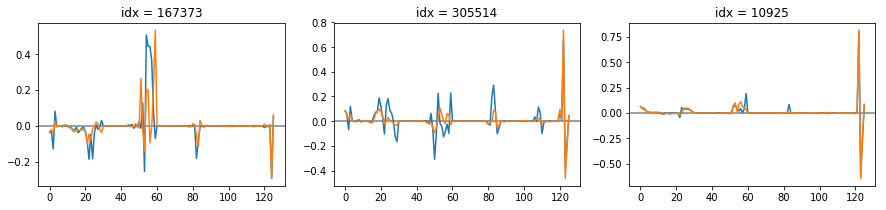

/export/home/srasp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


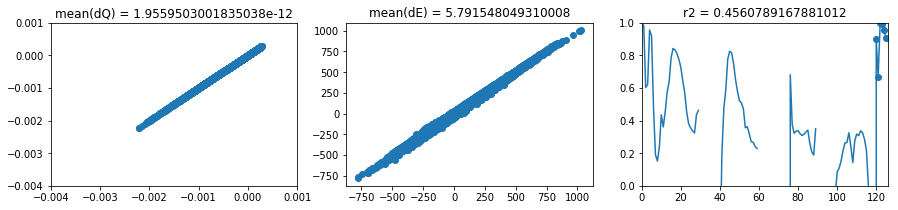

In [271]:
check_preds(None, preds=ppq)

In [288]:
def np_E_layer(arrs):
    """
    """
    x, a = arrs[0].copy(), arrs[1].copy()
    # Get pressure difference 
    PS = x[:, 120] * frange[120] + fmeans[120]
    P = P0 * hyai + PS[:, None] * hybi
    dP = P[:, 1:] - P[:, :-1]
    
    # Get Convective integrals --> Transform to energy units needed for conservation
    iTPHY, iPHQ, iPHCLDLIQ = a[:, :30]*dP/G, a[:, 30:60]*dP/G, a[:, 60:90]*dP/G/L_S*L_I
    vTPHY, vPHQ, vPHCLDLIQ = iTPHY.sum(1), iPHQ.sum(1), iPHCLDLIQ.sum(1)
    absvTPHY, absvPHQ, absvPHCLDLIQ = np.abs(iTPHY).sum(1), np.abs(iPHQ).sum(1), np.abs(iPHCLDLIQ).sum(1)
    # Sum for convective moisture
    dECONV = vTPHY + vPHQ + vPHCLDLIQ
    
    # Get surface fluxes
    SHFLX = x[:, 122] * frange[122] + fmeans[122]
    LHFLX = (x[:, 123] * frange[123] + fmeans[123]) / L_V * L_S
    dESRF = LHFLX + SHFLX
    
    # Radiative fluxes
    dERADFLX = np.sum(a[:, -4:], 1) * 1e3
    absRADFLX = np.sum(np.abs(a[:, -4:]), 1) * 1e3
    
    # Get precipitation sink
    TOT_PRECL = a[:, 120] / (24*3600*2e-2) * L_I
    TOT_PRECS = a[:, 121] / (24*3600*2e-2) * L_I
    dEPREC = TOT_PRECS - TOT_PRECL
    
    # Total differences to be corrected --> factor. Correct heating and 2D terms
    dE = dECONV - dERADFLX - dESRF - dEPREC
    absTOT = absvTPHY + absRADFLX + np.abs(TOT_PRECS)
    # Correct TPHY
    fact = dE[:, None] * np.abs(iTPHY) / absTOT[:, None]
    a[:, :30] -= fact / dP*G
    # Correct Radiative fluxes
    fact = dE[:, None] * np.abs(a[:, -4:]) * 1e3 / absTOT[:, None]
    a[:, -4:] += fact / 1e3
    # Correct precipitation sink
    fact = dE[:] * np.abs(TOT_PRECS) / absTOT[:]
    a[:, 121] += fact * (24*3600*2e-2) / L_I
    return a

In [289]:
ppe = np_E_layer([x_val, ppq])

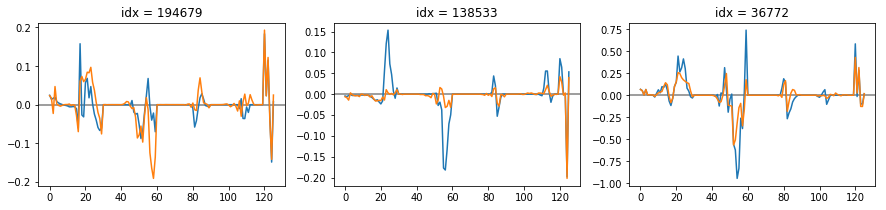

/export/home/srasp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


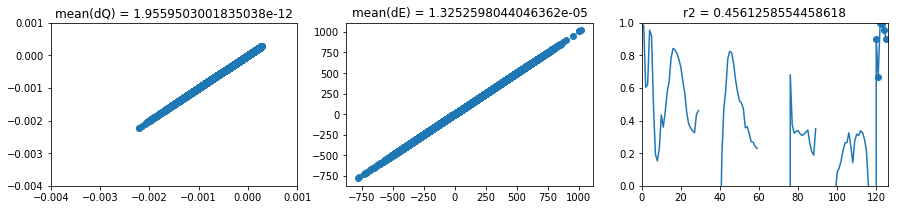

In [290]:
check_preds(None, preds=ppe)

#### Implementation

In [347]:
class QLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!

    def call(self, arrs):
        f, a = arrs
        # Get pressure difference 
        PS = f[:, 120] * frange[120] + fmeans[120]
        P = P0 * hyai + PS[:, None] * hybi
        dP = P[:, 1:] - P[:, :-1]

        # Get Convective integrals
        iPHQ, iPHCLDLIQ, iPHCLDICE = a[:, 30:60]*dP/G/L_S, a[:, 60:90]*dP/G/L_S, a[:, 90:120]*dP/G/L_S
        vPHQ, vPHCLDLIQ, vPHCLDICE = K.sum(iPHQ, 1), K.sum(iPHCLDLIQ, 1), K.sum(iPHCLDICE, 1)
        absvPHQ, absvPHCLDLIQ, absvPHCLDICE = K.sum(K.abs(iPHQ),1),K.sum(K.abs(iPHCLDLIQ),1),K.sum(K.abs(iPHCLDICE),1)
        # Sum for convective moisture
        dQCONV = vPHQ + vPHCLDLIQ + vPHCLDICE

        # Get surface flux
        LHFLX = (f[:, 123] * frange[123] + fmeans[123]) / L_V

        # Get precipitation sink
        TOT_PRECL = a[:, 120] / (24*3600*2e-2)

        # Total differences to be corrected --> factor. Correct everything involved
        #pdb.set_trace()
        dQ = dQCONV - LHFLX + TOT_PRECL
        absTOT = absvPHQ + absvPHCLDLIQ + absvPHCLDICE + K.abs(TOT_PRECL)
        # Correct PHQ
        fact = dQ[:, None] * K.abs(iPHQ) / absTOT[:, None]
        b = a[:, 30:60] - fact / dP*G*L_S
        # Correct PHCLDLIQ
        fact = dQ[:, None] * K.abs(iPHCLDLIQ) / absTOT[:, None]
        c = a[:, 60:90] - fact / dP*G*L_S
        # Correct PHCLDICE
        fact = dQ[:, None] * K.abs(iPHCLDICE) / absTOT[:, None]
        d = a[:, 90:120] - fact / dP*G*L_S
        # Correct precipitation sink
        fact = dQ[:] * K.abs(TOT_PRECL) / absTOT[:]
        e = a[:, 120] - fact * (24*3600*2e-2)

        return K.concatenate([a[:, :30], b, c, d, e[:, None], a[:, 121:]], 1)

    def compute_output_shape(self, input_shape):
        return input_shape[1]

In [341]:
class ELayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!

    def call(self, arrs):
        f, a = arrs
        # Get pressure difference 
        PS = f[:, 120] * frange[120] + fmeans[120]
        P = P0 * hyai + PS[:, None] * hybi
        dP = P[:, 1:] - P[:, :-1]

        # Get Convective integrals
        iTPHY, iPHQ, iPHCLDLIQ = a[:, :30]*dP/G, a[:, 30:60]*dP/G, a[:, 60:90]*dP/G/L_S*L_I
        vTPHY, vPHQ, vPHCLDLIQ = K.sum(iTPHY, 1), K.sum(iPHQ, 1), K.sum(iPHCLDLIQ, 1)
        absvTPHY, absvPHQ, absvPHCLDLIQ = K.sum(K.abs(iTPHY),1), K.sum(K.abs(iPHQ),1),K.sum(K.abs(iPHCLDLIQ),1)
        # Sum for convective moisture
        dECONV = vTPHY + vPHQ + vPHCLDLIQ

        # Get surface fluxes
        SHFLX = f[:, 122] * frange[122] + fmeans[122]
        LHFLX = (f[:, 123] * frange[123] + fmeans[123]) / L_V * L_S
        dESRF = LHFLX + SHFLX

        # Radiative fluxes
        dERADFLX = K.sum(a[:, -4:], 1) * 1e3
        absRADFLX = K.sum(K.abs(a[:, -4:]), 1) * 1e3

        # Get precipitation sink
        TOT_PRECL = a[:, 120] / (24*3600*2e-2) * L_I
        TOT_PRECS = a[:, 121] / (24*3600*2e-2) * L_I
        dEPREC = TOT_PRECS - TOT_PRECL
        
        # Total differences to be corrected --> factor. Correct heating and 2D terms
        dE = dECONV - dERADFLX - dESRF - dEPREC
        absTOT = absvTPHY + absRADFLX + K.abs(TOT_PRECS)
        # Correct TPHY
        fact = dE[:, None] * K.abs(iTPHY) / absTOT[:, None]
        b = a[:, :30] - fact / dP*G
        # Correct Radiative fluxes
        fact = dE[:, None] * K.abs(a[:, -4:]) * 1e3 / absTOT[:, None]
        c = a[:, -4:] + fact / 1e3
        # Correct precipitation sink
        fact = dE[:] * K.abs(TOT_PRECS) / absTOT[:]
        d = a[:, 121] + fact * (24*3600*2e-2) / L_I

        return K.concatenate([b, a[:, 30:121], d[:, None], c], 1)

    def compute_output_shape(self, input_shape):
        return input_shape[1]

In [360]:
inp = Input(shape=(x_trn.shape[1],))
x = LeakyReLU()(Dense(512)(inp))
x = LeakyReLU()(Dense(512)(x))
tmp = Dense(y_trn.shape[1])(x)
tmp = QLayer()([inp, tmp])
outp = ELayer()([inp, tmp])
eqnet = keras.models.Model(inp, outp)

In [361]:
eqnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 124)          0                                            
__________________________________________________________________________________________________
dense_59 (Dense)                (None, 512)          64000       input_24[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_36 (LeakyReLU)      (None, 512)          0           dense_59[0][0]                   
__________________________________________________________________________________________________
dense_60 (Dense)                (None, 512)          262656      leaky_re_lu_36[0][0]             
__________________________________________________________________________________________________
leaky_re_l

#### Train

In [362]:
eqnet.compile('adam', 'mse')

In [363]:
eqnet.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 1564672 samples, validate on 393216 samples
Epoch 1/10
1564672/1564672 [==============================] - 43s 28us/step - loss: 0.0032 - val_loss: 0.0029
Epoch 2/10
1564672/1564672 [==============================] - 42s 27us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 3/10
1564672/1564672 [==============================] - 43s 28us/step - loss: 0.0028 - val_loss: 0.0027
Epoch 4/10
1564672/1564672 [==============================] - 43s 27us/step - loss: 0.0028 - val_loss: 0.0027
Epoch 5/10
1564672/1564672 [==============================] - 43s 27us/step - loss: 0.0028 - val_loss: 0.0027
Epoch 6/10
1564672/1564672 [==============================] - 43s 27us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 7/10
1564672/1564672 [==============================] - 41s 26us/step - loss: 0.0027 - val_loss: 0.0026
Epoch 8/10
1564672/1564672 [==============================] - 43s 27us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 9/10
1564672/1564672 [==============================] - 43s 2

In [364]:
eqnet.optimizer.lr = 1e-4

In [365]:
eqnet.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 1564672 samples, validate on 393216 samples
Epoch 1/10
1564672/1564672 [==============================] - 43s 27us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 2/10
1564672/1564672 [==============================] - 43s 27us/step - loss: 0.0027 - val_loss: 0.0026
Epoch 3/10
1564672/1564672 [==============================] - 43s 27us/step - loss: 0.0027 - val_loss: 0.0026
Epoch 4/10
1564672/1564672 [==============================] - 43s 27us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 5/10
1564672/1564672 [==============================] - 42s 27us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 6/10
 148480/1564672 [=>............................] - ETA: 36s - loss: 0.0026

KeyboardInterrupt: 

In [ ]:
eqnet.optimizer.lr = 1e-5
eqnet.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

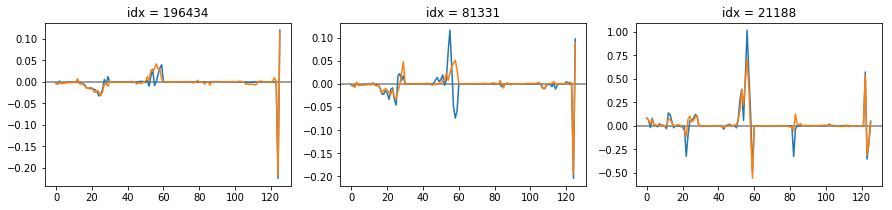

/export/home/srasp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


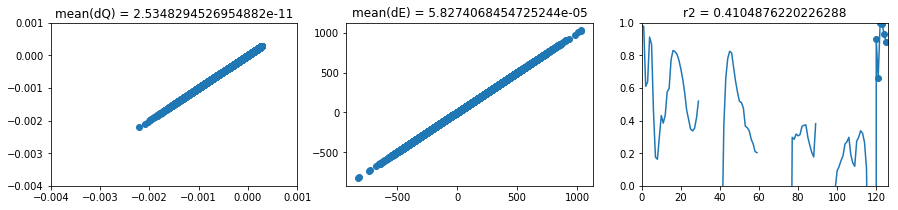

In [366]:
check_preds(eqnet)

## MSE conservation

In [71]:
# Load the data
DATA_DIR = '/beegfs/DATA/pritchard/srasp/Aquaplanet_enhance05/'
n_days = 1
ds = xr.open_mfdataset(
    f'{DATA_DIR}AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-0[1-{n_days}]*',
    decode_times=False)

In [72]:
print(sorted(list(ds.data_vars.keys())))

['DTV', 'DTVKE', 'FLUT', 'LHFLX', 'OMEGA', 'P0', 'PHCLDICE', 'PHCLDLIQ', 'PHQ', 'PRECC', 'PRECL', 'PRECSC', 'PRECSL', 'PRECSTEN', 'PRECT', 'PRECTEND', 'PS', 'QAP', 'QBP', 'QCAP', 'QIAP', 'QRL', 'QRS', 'SHFLX', 'SOLIN', 'SPDQ', 'SPDQC', 'SPDQI', 'SPDT', 'SPQC', 'SPQI', 'SRFRAD', 'T', 'TAP', 'TBP', 'TPHYSTND', 'TPHYSTND_NORAD', 'TS', 'UAP', 'UPHYSTND', 'VAP', 'VD01', 'VPHYSTND', 'dQdt_adiabatic', 'dTdt_adiabatic', 'date', 'date_written', 'datesec', 'gw', 'hyai', 'hyam', 'hybi', 'hybm', 'mdt', 'nbdate', 'nbsec', 'ndbase', 'ndcur', 'nlon', 'nsbase', 'nscur', 'nsteph', 'ntrk', 'ntrm', 'ntrn', 'time_bnds', 'time_written', 'wnummax']


In [73]:
# Add NORAD term to dataset
ds['TPHYSTND_NORAD'] = ds.TPHYSTND - ds.QRL - ds.QRS

In [74]:
ds = ds.isel(time=slice(1, None))

### Energy conservation from raw data

- TPHYSTND = SPDT + QRL + QRS + DTV(t-1)
- DTV = SHFLX / C_P / dt

vint(TPHYSTND) + vint(PHQ) = SHFLX + LHFLX + engy(PREC) 

#### Check assumptions

In [180]:
def rel_hist(left, right):
    left = left.values
    right = right.values
    mean = (np.mean(left) + np.mean(right)) / 2
    print(mean)
    rel = ((left - right)/mean)
    plt.hist(rel.flat, bins=100, range=(rel.min(), rel.max()))
    plt.gca().set_yscale('log')

88.7057830628116


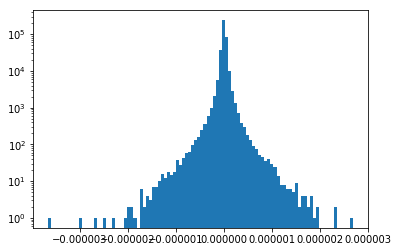

In [181]:
rel_hist(
    vint(ds, 'TPHYSTND_NORAD', C_P),
    (vint(ds, 'SPDT', C_P) + vint(ds, 'DTV', C_P))
)

-5.2528820847287365


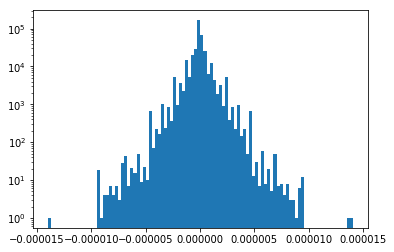

In [124]:
rel_hist(
    vint(ds, 'PHQ', L_S),
    (vint(ds, 'SPDQ', L_S) + vint(ds, 'VD01', L_S))
)

-0.03631219737881281


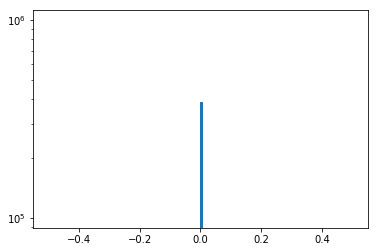

In [111]:
rel_hist(
    vint(ds, 'PHCLDLIQ', L_V),
    vint(ds, 'SPDQC', L_V)
)

-8.323711300564797


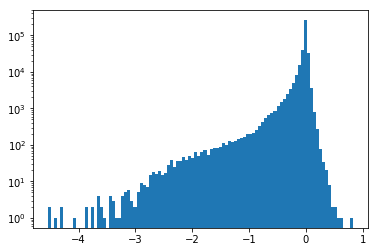

In [117]:
# Precipitation term
dprec = ((ds.PRECSC + ds.PRECSL)*1e3 + ds.PRECSTEN - (ds.PRECT*1e3 + ds.PRECTEND))*L_I
# Pure SP terms
dsp = vint(ds, 'SPDT', C_P) + vint(ds, 'SPDQ', L_S) + vint(ds, 'SPDQC', L_I)
rel_hist(dprec, dsp)

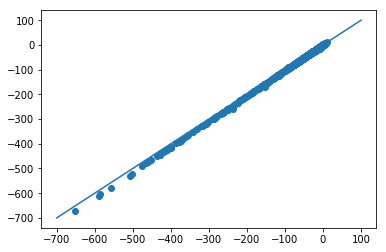

In [120]:
plt.scatter(dprec.isel(time=-1).values.flat, dsp.isel(time=-1).values.flat)
plt.plot([-700, 100], [-700, 100])

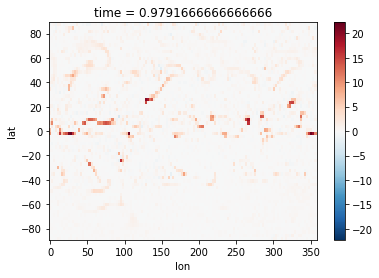

In [100]:
(dprec - dsp).isel(time=-1).plot();

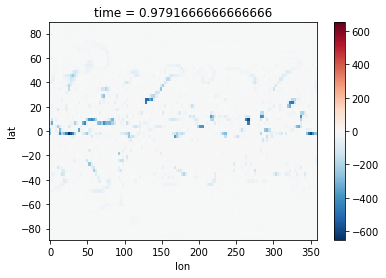

In [136]:
dprec.isel(time=-1).plot();

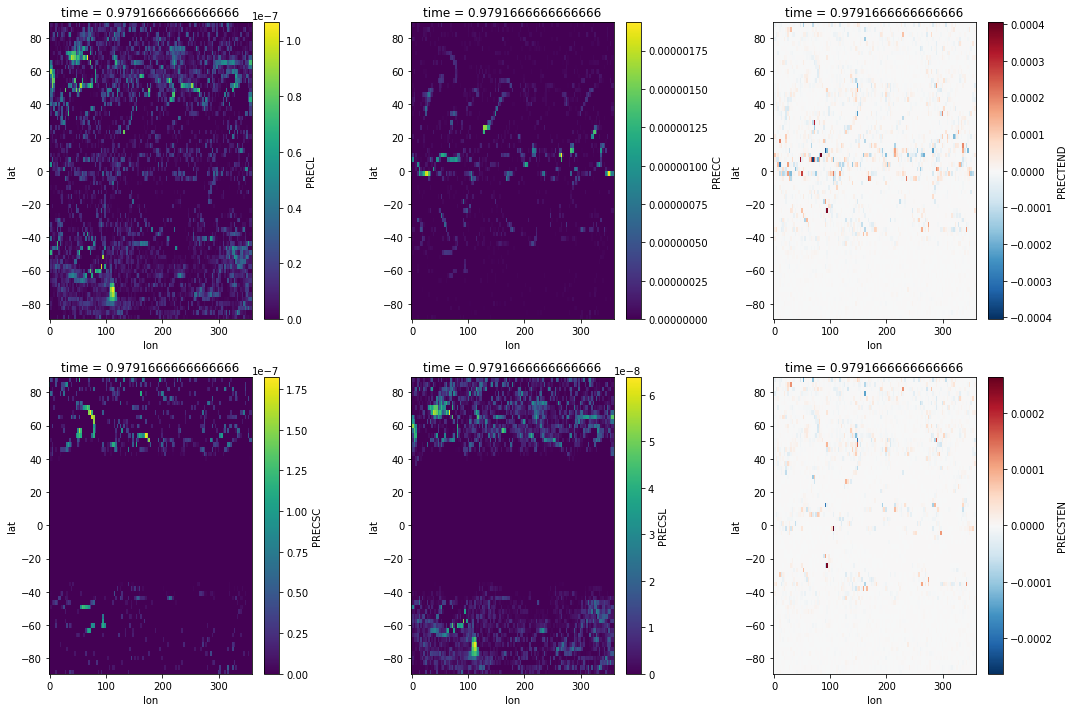

In [87]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for ax, v in zip(axes.flat, ['PRECL', 'PRECC', 'PRECTEND', 'PRECSC', 'PRECSL', 'PRECSTEN']):
    ds[v].isel(time=-1).plot(ax=ax)
plt.tight_layout()

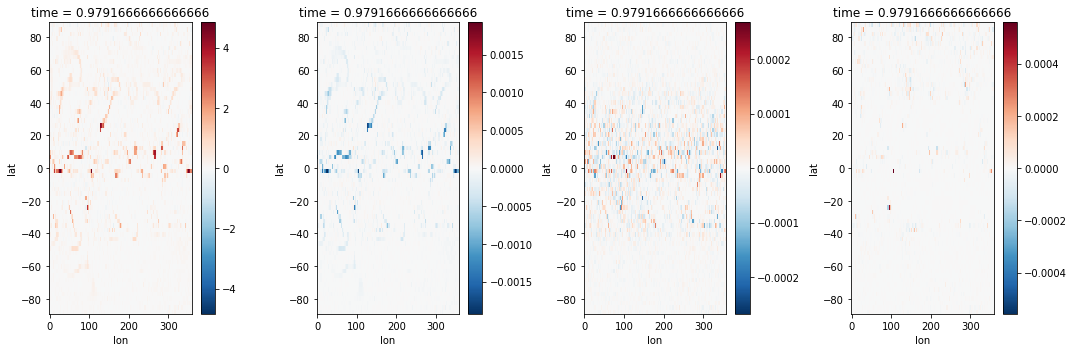

In [113]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for ax, v in zip(axes.flat, ['SPDT', 'SPDQ', 'SPDQC', 'SPDQI']):
    vint(ds, v, 1).isel(time=-1).plot(ax=ax)
plt.tight_layout()

In [182]:
dturb = vint(ds, 'DTV', C_P) + vint(ds, 'VD01', L_S)
dconv = vint(ds, 'TPHYSTND_NORAD', C_P) + vint(ds, 'PHQ', L_S) + vint(ds, 'PHCLDLIQ', L_I)
dsp = vint(ds, 'SPDT', C_P) + vint(ds, 'SPDQ', L_S) + vint(ds, 'SPDQC', L_I)

83.44805596398238


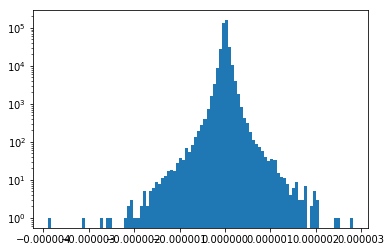

In [128]:
rel_hist(
    dconv,
    (dsp + dturb)
)

83.6231926293201


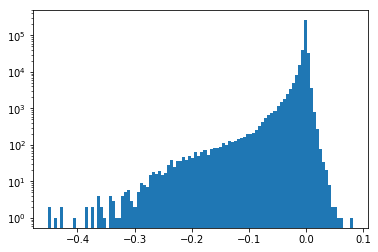

In [129]:
rel_hist(
    dconv,
    (dprec + dturb)
)

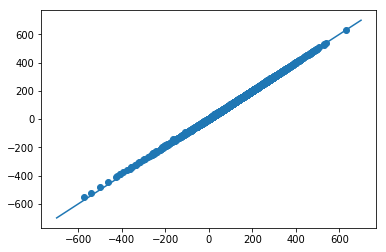

In [131]:
plt.scatter(dconv.isel(time=-1).values.flat, (dprec + dturb).isel(time=-1).values.flat)
plt.plot([-700, 700], [-700, 700])

In [184]:
dconv.std().values

array(101.56516197)

#### How important is the KE Diffusion term?

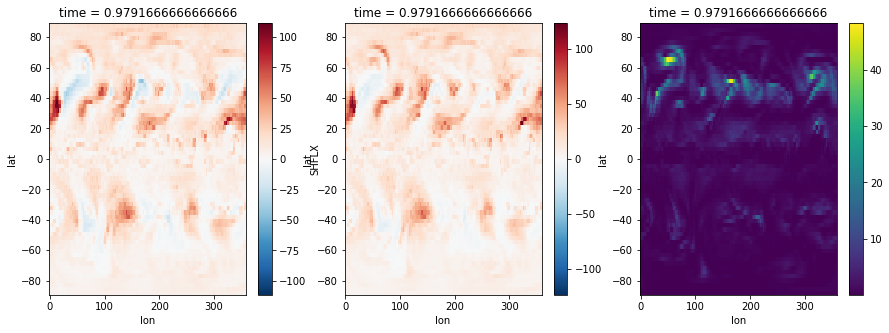

In [132]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ds.SHFLX.isel(time=-1).plot(ax=axes[0])
vint(ds, 'DTV', C_P).isel(time=-1).plot(ax=axes[1])
vint(ds, 'DTVKE', C_P/1800.).isel(time=-1).plot(ax=axes[2]);

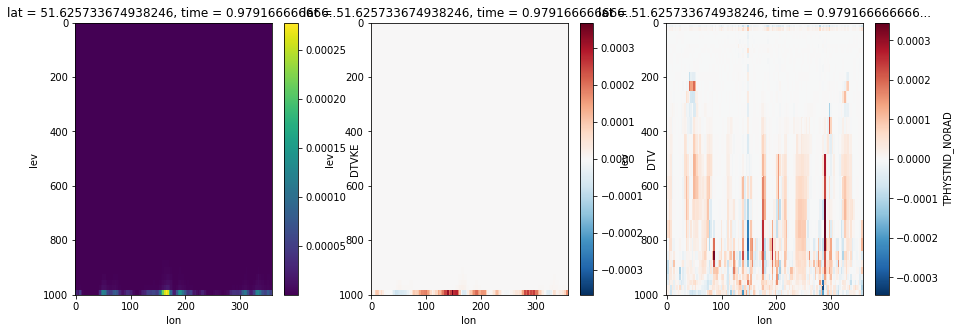

In [140]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
(ds.DTVKE/1800).isel(time=-1, lat=50).plot(yincrease=False, ax=axes[0]);
ds.DTV.isel(time=-1, lat=50).plot(yincrease=False, ax=axes[1]);
ds.TPHYSTND_NORAD.isel(time=-1, lat=50).plot(yincrease=False, ax=axes[2]);

Definitely not negligible! In vertical_diffusion.F90 it seems like the application of DTVKE happens independently from the application of the surface fluxes. This means it is unaffected by FBP.

One idea would be to predict TPHYSTND_NORAD - DTVKE, because it is a source term that I cannot account for at the moment.

DTVKE is a source term of static energy. But remember DTV = DTVKE + SHFLX. It is only active at the surface though. 

#### More stuff

In [5]:
# Get statistics for a single grid point
ilat, ilon, itime = 0, 0, -1

In [6]:
a = ds.TPHYSTND_NORAD.isel(lat=ilat, lon=ilon, time=itime).values

In [7]:
def fl2hr(ds, var):
    tmp1 = G/get_dP_from_ds(ds).isel(lev=-1)
    fac = C_P if var == 'SHFLX' else L_V
    return ds[var] * tmp1 / fac

In [8]:
b = ds.SPDT.isel(lat=ilat, lon=ilon, time=itime).values
#b[-1] += fl2hr(ds, 'SHFLX').isel(lat=ilat, lon=ilon, time=itime-1).values
b[-1] += fl2hr(ds, 'SHFLX').isel(lat=ilat, lon=ilon, time=itime).values

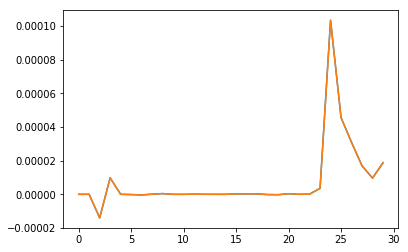

In [9]:
plt.plot(a); plt.plot(b);

In [10]:
# Precipitation term
dprec = ((ds.PRECSC + ds.PRECSL)*1e3 + ds.PRECSTEN - (ds.PRECT*1e3 + ds.PRECTEND))*L_I

In [11]:
# Surface terms
dsurf = ds.LHFLX + ds.SHFLX

In [38]:
# Turbulence terms
dturb = vint(ds, 'DTV', C_P) + vint(ds, 'VD01', L_V)

In [13]:
# Convection terms
dconv = vint(ds, 'TPHYSTND_NORAD', C_P) + vint(ds, 'PHQ', L_S) + vint(ds, 'PHCLDLIQ', L_I)

In [14]:
# Pure SP terms
dsp = vint(ds, 'SPDT', C_P) + vint(ds, 'SPDQ', L_S) + vint(ds, 'SPDQC', L_I)

In [15]:
tmp = [d.isel(time=itime, lat=ilat, lon=ilon).values for d in [dprec, dconv, dsp]]

In [16]:
#tmp += [dsurf.isel(time=itime-1, lat=ilat, lon=ilon).values]
tmp += [dsurf.isel(time=itime, lat=ilat, lon=ilon).values]

In [17]:
tmp

[array(-0.3103447, dtype=float32),
 array(19.97527367),
 array(-0.54724313),
 array(18.676828, dtype=float32)]

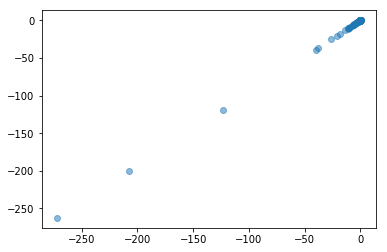

In [23]:
plt.scatter(
    dsp.isel(time=itime, lon=0).values.flat, 
    dprec.isel(time=itime, lon=0).values.flat, alpha=0.5)

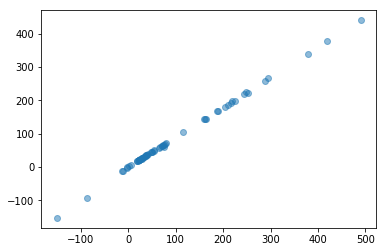

In [39]:
plt.scatter(
    dconv.isel(time=itime, lon=0).values.flat, 
    (dprec.isel(time=itime, lon=0).values + dturb.isel(time=itime, lon=0).values).flat, 
    alpha=0.5)

In [40]:
dE = (
    dconv.isel(time=itime) - 
    dprec.isel(time=itime) - 
#    dsurf.isel(time=itime-1).values
    dturb.isel(time=itime).values
)

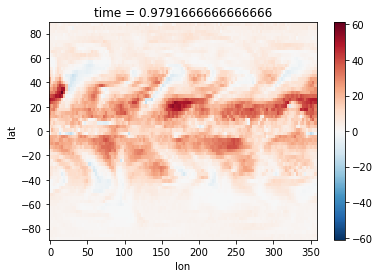

In [41]:
dE.plot();

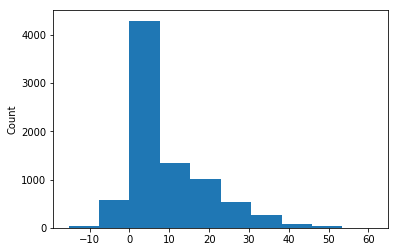

In [42]:
dE.plot.hist();

In [30]:
dE2 = (
    dsp.isel(time=itime) - 
    dprec.isel(time=itime)
)

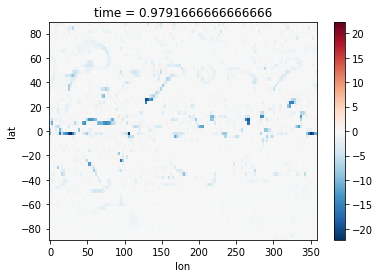

In [31]:
dE2.plot();

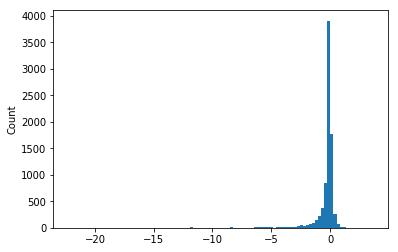

In [33]:
dE2.plot.hist(bins=100);

### Prepare data
- Inputs: ['TBP', 'QBP', 'QCBP', 'QIBP', 'DTV', 'VD01', 'PS'] --> Normalized with max(std, eps)
- Outputs: [TPHYSTND_NORAD\*C_P, PHQ\*L_S, PHCLDLIQ\*L_S, PHCLDICE\*L_S, TOT_PRECL$*24*3600*1e-2$, TOT_PRECS$*24*3600*1e-2$]
- TOT_PRECL = (PRECT\*1e3 + PRECTEND)
- TOT_PRECS = (PRECSC + PRECSL)\*1e3 + PRECSTEN

In [76]:
ds['TBP'] = ds['TAP'] - ds['TPHYSTND']*dt
ds['QBP'] = ds['QAP'] - ds['PHQ']*dt
ds['QCBP'] = ds['QCAP'] - ds['PHCLDLIQ']*dt
ds['QIBP'] = ds['QIAP'] - ds['PHCLDICE']*dt

In [77]:
ds['TOT_PRECL'] = ds['PRECT']*1e3 + ds['PRECTEND']
ds['TOT_PRECS'] = (ds['PRECSC'] + ds['PRECSL'])*1e3 + ds['PRECSTEN']

In [78]:
inpvars = ['TBP', 'QBP', 'QCBP', 'QIBP', 'DTV', 'VD01', 'PS']
outpvars = ['TPHYSTND_NORAD', 'PHQ', 'PHCLDLIQ', 'PHCLDICE', 'TOT_PRECL', 'TOT_PRECS']

In [132]:
# According to my December thinking the factor for precip should be 1e3*24*3600 * 1e-3
# The 1e3 was already done above
# But then it's pretty small and I want it to be weighted quite a lot
outpfacts = [C_P, L_S, L_S, L_S, 24*3600*1e-2, 24*3600*1e-2, ]

In [134]:
f = concat_ds(ds, inpvars)

In [135]:
t = concat_ds(ds, outpvars, outpfacts)

In [136]:
f.shape, t.shape

((385024, 181), (385024, 122))

In [137]:
# Normalize features
fmeans = f.mean(0)
fstds = np.maximum(f.std(0), 1e-11)

In [138]:
norm = lambda x: (x - fmeans) / fstds
denorm = lambda x: x * fstds + fmeans

In [139]:
f = norm(f)

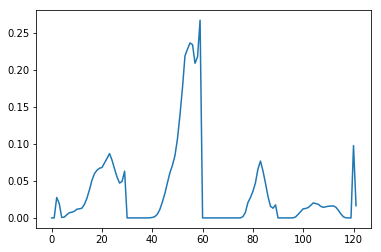

In [140]:
plt.plot(t.std(0));

In [141]:
ngeo = 64*128
def split(f, t, nt=40):
    return f[:nt*ngeo], f[nt*ngeo:], t[:nt*ngeo], t[nt*ngeo:]

In [142]:
x_trn, x_val, y_trn, y_val = split(f, t)
x_trn.shape, x_val.shape

((327680, 181), (57344, 181))

### Reference network

In [143]:
inp = Input(shape=(x_trn.shape[1],))
x = LeakyReLU()(Dense(256)(inp))
x = LeakyReLU()(Dense(256)(x))
outp = Dense(y_trn.shape[1])(x)
net = keras.models.Model(inp, outp)

In [144]:
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 181)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               46592     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 122)               31354     
Total params: 143,738
Trainable params: 143,738
Non-trainable params: 0
_________________________________________________________________


In [145]:
net.compile('adam', 'mse')

In [146]:
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.0112 - val_loss: 0.0040
Epoch 2/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.0043 - val_loss: 0.0039
Epoch 3/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.0041 - val_loss: 0.0034
Epoch 4/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0040 - val_loss: 0.0034
Epoch 5/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0036 - val_loss: 0.0033
Epoch 6/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0035 - val_loss: 0.0032
Epoch 7/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0034 - val_loss: 0.0032
Epoch 8/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0034 - val_loss: 0.0036
Epoch 9/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0037 - val

In [147]:
net.optimizer.lr = 1e-4
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0032 - val_loss: 0.0030
Epoch 2/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0031 - val_loss: 0.0030
Epoch 3/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 4/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 5/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0029 - val_loss: 0.0029
Epoch 6/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 8/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0029 - val_loss: 0.0029
Epoch 9/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0028 - val

In [148]:
net.optimizer.lr = 1e-5
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0027 - val_loss: 0.0028
Epoch 2/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 3/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 4/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0027 - val_loss: 0.0028
Epoch 5/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0027 - val_loss: 0.0028
Epoch 6/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 7/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0026 - val_loss: 0.0027
Epoch 8/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0026 - val_loss: 0.0028
Epoch 9/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0027 - val

In [149]:
preds = net.predict(x_val, 4048)

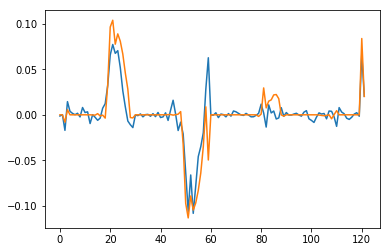

In [150]:
i=2000
plt.plot(preds[i]); plt.plot(y_val[i])

In [151]:
preds_re = preds.reshape(-1, 64, 128, preds.shape[-1])
val_re = y_val.reshape(-1, 64, 128, preds.shape[-1])

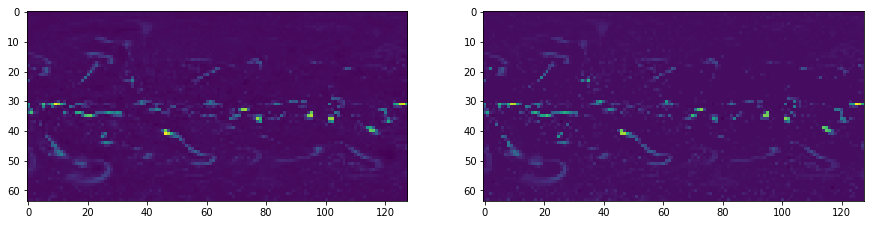

In [152]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(preds_re[0, : , :, -2])
axes[1].imshow(val_re[0, : , :, -2]);

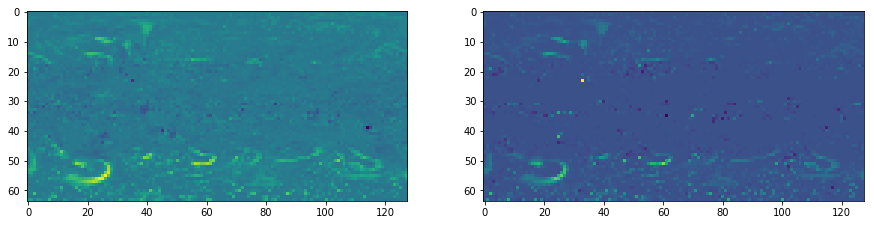

In [153]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(preds_re[0, : , :, -1])
axes[1].imshow(val_re[0, : , :, -1]);

### Numpy energy conservation layer

In [130]:
hyai, hybi, P0 = ds.hyai.values, ds.hybi.values, ds.P0.values

- dturb = vint(ds, 'DTV', C_P) + vint(ds, 'VD01', L_S)
- dconv = vint(ds, 'TPHYSTND_NORAD', C_P) + vint(ds, 'PHQ', L_S) + vint(ds, 'PHCLDLIQ', L_I)
- dprec = ((ds.PRECSC + ds.PRECSL)*1e3 + ds.PRECSTEN - (ds.PRECT*1e3 + ds.PRECTEND))*L_I

In [ ]:
def np_energy_layer(arrs):
    """
    - Inputs: [PS, SOLIN, TAP(z), QAP(z)]
    - Outputs: [FSNT, -FSNS, -FLNT, FLNS, QRL(z), QRS(z)]
    f(eatures) -> 62 layers
    a(ctivations) -> 63 layers
    """
    f, a = arrs
    PS = f[:, 0] * fstds[0] + fmeans[0]
    P = P0 * hyai + PS[:, None] * hybi
    dP = P[:, 1:] - P[:, :-1]
    vintQRL = np.sum(a[:, -60:-30]*dP/G, 1)
    vintQRS = np.sum(a[:, -30:]*dP/G, 1)
    F2to4 = np.sum(a[:, :3], 1) * 1e4
    F1 = (vintQRL + vintQRS - F2to4) / 1e4
    return np.concatenate([np.reshape(F1, (-1, 1)), a], 1)

In [171]:
def vint_np(a, dP): return np.sum(a*dP/G, 1)

In [223]:
def np_mse_layer(arrs):
    # Destructure input arrays
    f, a = arrs
#     pdb.set_trace()
    # Split arrays
    tmp = f * fstds + fmeans
    DTV, VD01, PS = tmp[:,120:150], tmp[:,150:180], tmp[:,-1]   # Now in actual units
    TPHY, PHQ, PHQC, PHQI, PRECL, PRECS = a[:, :30], a[:, 30:60], a[:, 60:90], a[:, 90:120], a[:, 120], a[:, 121]
    # Get pressure differences
    P = P0 * hyai + PS[:, None] * hybi
    dP = P[:, 1:] - P[:, :-1]
    # Compute vertical integrals and convert to energy units
    vDTV, vVD01, vTPHY = vint_np(DTV, dP)*C_P, vint_np(VD01, dP)*L_S, vint_np(TPHY, dP)
    vPHQ, vPHQC, vPHQI = vint_np(PHQ, dP), vint_np(PHQC, dP)/L_S*L_I, vint_np(PHQI, dP)
    # Compute precip energy sink
    dPREC = (PRECS/(24*3600*1e-2) - PRECL/(24*3600*1e-2))*L_I
    # Compute convective and turbulent totals
    dCONV = vTPHY + vPHQ + vPHQC
    dTURB = vDTV + vVD01
    # Compute energy loss
    dE = dCONV - dTURB - dPREC
    return dCONV, dTURB, dPREC, dE

In [219]:
tmp = np_mse_layer([x_val[-ngeo:], y_val[-ngeo:]])

> <ipython-input-218-e5e61ef31013>(6)np_mse_layer()
-> tmp = f * fstds + fmeans
(Pdb) c


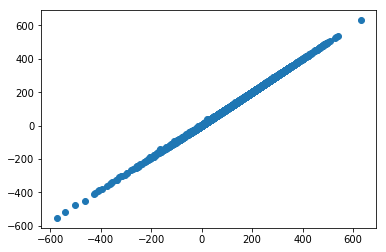

In [222]:
plt.scatter(tmp[0].flat, (tmp[1]+tmp[2]).flat)

## Radiation conservation

vint(QRL)C_P + vint(QRS)C_P = FSNT - FSNS -FLNT + FLNS

In [6]:
n_days = 1

In [7]:
# Load the data
DATA_DIR = '/beegfs/DATA/pritchard/srasp/fluxbypass_aqua/'
n_days = 1
ds = xr.open_mfdataset(
    f'{DATA_DIR}AndKua_aqua_SPCAM3.0_sp_fbp_f2.cam2.h1.0000-01-0[1-{n_days}]*',
    decode_times=False)

In [8]:
ds = ds.isel(time=slice(1, None))

In [9]:
ds['TBP'] = ds['TAP'] - ds['TPHYSTND']*dt
ds['QBP'] = ds['QAP'] - ds['PHQ']*dt

In [10]:
print(sorted(list(ds.data_vars.keys())))

['DTV', 'FLNS', 'FLNT', 'FLUT', 'FSNS', 'FSNT', 'LHFLX', 'P0', 'PHQ', 'PRECC', 'PRECL', 'PRECSC', 'PRECSL', 'PRECSTEN', 'PRECT', 'PRECTEND', 'PS', 'QAP', 'QBP', 'QRL', 'QRS', 'SHFLX', 'SOLIN', 'SPDQ', 'SPDT', 'T', 'TAP', 'TBP', 'TPHYSTND', 'TS', 'UAP', 'VAP', 'VD01', 'date', 'date_written', 'datesec', 'gw', 'hyai', 'hyam', 'hybi', 'hybm', 'mdt', 'nbdate', 'nbsec', 'ndbase', 'ndcur', 'nlon', 'nsbase', 'nscur', 'nsteph', 'ntrk', 'ntrm', 'ntrn', 'time_bnds', 'time_written', 'wnummax']


In [11]:
hyai, hybi, P0 = ds.hyai.values, ds.hybi.values, ds.P0.values

### What are these F terms anyway?

In [225]:
ds.FSNT.long_name

'Net solar flux at top of model'

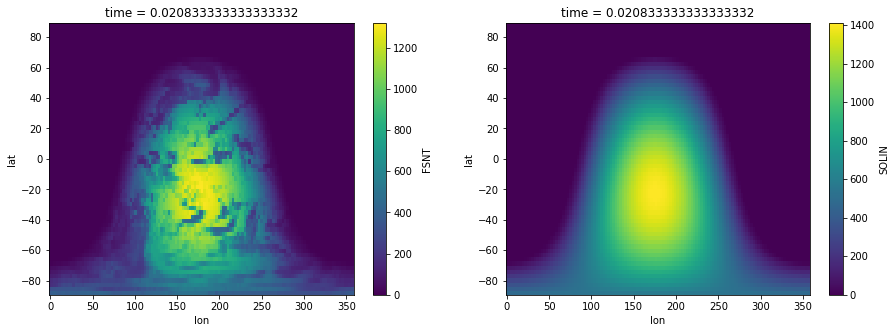

In [226]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
ds.FSNT.isel(time=1).plot(ax=axes[0])
ds.SOLIN.isel(time=1).plot(ax=axes[1]);

In [420]:
ds.FSNS.long_name

'Net solar flux at surface'

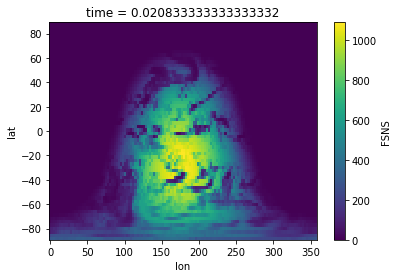

In [422]:
ds.FSNS.isel(time=1).plot();

In [424]:
ds.FLNT.long_name

'Net longwave flux at top of model'

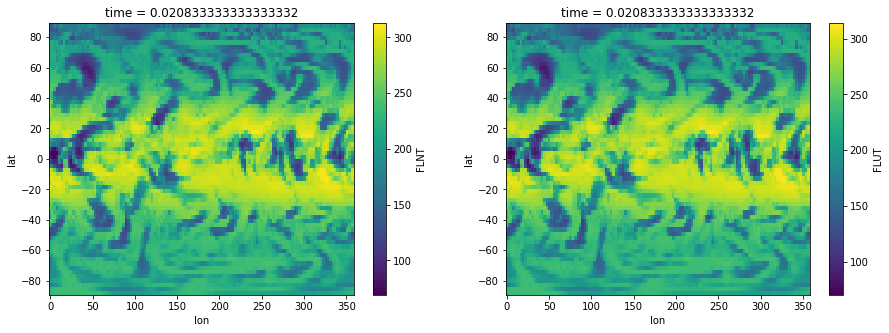

In [425]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
ds.FLNT.isel(time=1).plot(ax=axes[0])
ds.FLUT.isel(time=1).plot(ax=axes[1]);

In [426]:
ds.FLNS.long_name

'Net longwave flux at surface'

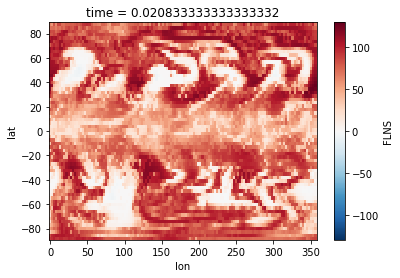

In [427]:
ds.FLNS.isel(time=1).plot();

### Test from raw data

In [12]:
flx_net = ds.FSNT - ds.FSNS - ds.FLNT + ds.FLNS

In [13]:
drad = vint(ds, 'QRL', C_P) + vint(ds, 'QRS', C_P)

In [14]:
ilat, ilon, itime = 32, 0, -1

In [15]:
flx_net.isel(time=itime, lat=ilat, lon=ilon).values

array(-97.08189, dtype=float32)

In [16]:
drad.isel(time=itime, lat=ilat, lon=ilon).values

array(-96.59567565)

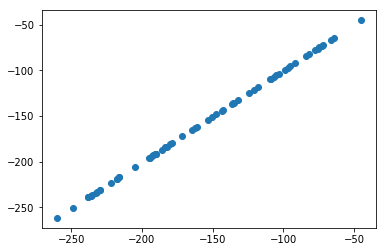

In [17]:
plt.scatter(drad.isel(lon=0, time=itime), flx_net.isel(lon=0, time=itime));

### Prepare data

- Inputs: [PS, SOLIN, TAP(z), QAP(z)]
- Outputs: [FSNT, -FSNS, -FLNT, FLNS, QRL(z), QRS(z)]

In [18]:
inpvars = ['PS', 'SOLIN', 'TBP', 'QBP']
outpvars = ['FSNT', 'FSNS', 'FLNT', 'FLNS', 'QRL', 'QRS']
outpfacts = [1e-4, -1e-4, -1e-4, 1e-4, C_P, C_P]

In [19]:
f = concat_ds(ds, inpvars)

In [20]:
# Normalize features
fmeans = f.mean(0)
fstds = f.std(0) # np.maximum(f.std(0), 1e-11)

In [21]:
norm = lambda x: (x - fmeans) / fstds
denorm = lambda x: x * fstds + fmeans

In [22]:
f = norm(f)

In [23]:
t = concat_ds(ds, outpvars, outpfacts)

In [24]:
x_trn, x_val, y_trn, y_val = split(f, t, 40)
x_trn.shape, x_val.shape

((327680, 62), (57344, 62))

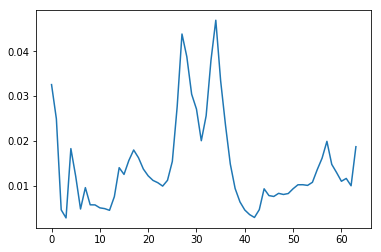

In [25]:
plt.plot(y_val.std(0));

### Reference network

Two layers with 256 nodes.

In [26]:
inp = Input(shape=(62,))
x = LeakyReLU()(Dense(256)(inp))
x = LeakyReLU()(Dense(256)(x))
outp = Dense(64)(x)
net = keras.models.Model(inp, outp)

In [27]:
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 62)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16128     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
Total params: 98,368
Trainable params: 98,368
Non-trainable params: 0
_________________________________________________________________


#### Training

In [28]:
net.compile('adam', 'mse')

In [29]:
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 5s 16us/step - loss: 0.0034 - val_loss: 4.5431e-04
Epoch 2/10
327680/327680 [==============================] - 4s 11us/step - loss: 3.6723e-04 - val_loss: 2.8094e-04
Epoch 3/10
327680/327680 [==============================] - 4s 11us/step - loss: 2.6911e-04 - val_loss: 2.2274e-04
Epoch 4/10
327680/327680 [==============================] - 4s 11us/step - loss: 2.2856e-04 - val_loss: 1.9453e-04
Epoch 5/10
327680/327680 [==============================] - 4s 11us/step - loss: 2.0613e-04 - val_loss: 1.7676e-04
Epoch 6/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.9142e-04 - val_loss: 1.6661e-04
Epoch 7/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.8084e-04 - val_loss: 1.5743e-04
Epoch 8/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.7254e-04 - val_loss: 1.5058e-04
Epoch 9/10
327680/327680 [=======

In [30]:
net.optimizer.lr = 1e-4

In [31]:
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.5588e-04 - val_loss: 1.4007e-04
Epoch 2/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.5118e-04 - val_loss: 1.3384e-04
Epoch 3/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.4673e-04 - val_loss: 1.3279e-04
Epoch 4/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.4201e-04 - val_loss: 1.2712e-04
Epoch 5/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.3899e-04 - val_loss: 1.2862e-04
Epoch 6/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.3498e-04 - val_loss: 1.2585e-04
Epoch 7/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.3113e-04 - val_loss: 1.2091e-04
Epoch 8/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.2835e-04 - val_loss: 1.1640e-04
Epoch 9/10
327680/327680 [===

In [32]:
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.1764e-04 - val_loss: 1.1317e-04
Epoch 2/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.1510e-04 - val_loss: 1.0766e-04
Epoch 3/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.1278e-04 - val_loss: 1.0664e-04
Epoch 4/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.0954e-04 - val_loss: 1.0330e-04
Epoch 5/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.0701e-04 - val_loss: 1.0046e-04
Epoch 6/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.0530e-04 - val_loss: 1.0089e-04
Epoch 7/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.0279e-04 - val_loss: 9.5828e-05
Epoch 8/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.0109e-04 - val_loss: 9.5932e-05
Epoch 9/10
327680/327680 [===

In [33]:
net.optimizer.lr = 1e-5
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 11us/step - loss: 9.5660e-05 - val_loss: 9.2581e-05
Epoch 2/10
327680/327680 [==============================] - 4s 11us/step - loss: 9.3931e-05 - val_loss: 9.0791e-05
Epoch 3/10
327680/327680 [==============================] - 4s 11us/step - loss: 9.2294e-05 - val_loss: 8.7577e-05
Epoch 4/10
327680/327680 [==============================] - 4s 11us/step - loss: 9.1457e-05 - val_loss: 8.9404e-05
Epoch 5/10
327680/327680 [==============================] - 4s 11us/step - loss: 8.9842e-05 - val_loss: 8.6459e-05
Epoch 6/10
327680/327680 [==============================] - 4s 11us/step - loss: 8.8705e-05 - val_loss: 8.7592e-05
Epoch 7/10
327680/327680 [==============================] - 4s 11us/step - loss: 8.6716e-05 - val_loss: 8.6497e-05
Epoch 8/10
327680/327680 [==============================] - 4s 11us/step - loss: 8.6505e-05 - val_loss: 8.2869e-05
Epoch 9/10
327680/327680 [===

In [34]:
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 11us/step - loss: 8.2967e-05 - val_loss: 8.2551e-05
Epoch 2/10
327680/327680 [==============================] - 4s 11us/step - loss: 8.2414e-05 - val_loss: 8.1094e-05
Epoch 3/10
327680/327680 [==============================] - 4s 11us/step - loss: 8.1220e-05 - val_loss: 8.2788e-05
Epoch 4/10
327680/327680 [==============================] - 4s 11us/step - loss: 8.0055e-05 - val_loss: 7.9593e-05
Epoch 5/10
327680/327680 [==============================] - 4s 11us/step - loss: 7.9239e-05 - val_loss: 8.0834e-05
Epoch 6/10
327680/327680 [==============================] - 4s 11us/step - loss: 7.8553e-05 - val_loss: 7.7487e-05
Epoch 7/10
327680/327680 [==============================] - 4s 11us/step - loss: 7.7650e-05 - val_loss: 8.0278e-05
Epoch 8/10
327680/327680 [==============================] - 4s 11us/step - loss: 7.7014e-05 - val_loss: 7.7945e-05
Epoch 9/10
327680/327680 [===

#### Evaluation

In [35]:
def get_dE(x, y):
    PS = x[:, 0] * fstds[0] + fmeans[0]
    P = P0 * hyai + PS[:, None] * hybi
    dP = P[:, 1:] - P[:, :-1]
    vintQRL = np.sum(y[:, -60:-30]*dP/G, 1)
    vintQRS = np.sum(y[:, -30:]*dP/G, 1)
    #F1to3 = np.sum(y[:, :3]*signs[:3], 1) * 1e4
    F1to4 = np.sum(y[:, :4], 1) * 1e4
    #F4 = (vintQRL + vintQRS - F1to3) / 1e4
    #out_y = np.concatenate([y, np.reshape(F4, (-1, 1))], 1)
    return vintQRL + vintQRS, F1to4

In [110]:
def check_preds(m, s='val', preds=None):
    x, y = (x_val, y_val) if s == 'val' else (x_trn, y_trn)
    preds = m.predict(x, batch_size=1024) if preds is None else preds
    a, b = get_dE(x, preds)
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))
    for ax in axes.flat:
        idx = np.random.randint(0, x.shape[0])
        ax.plot(y[idx]); ax.plot(preds[idx])
        ax.set_title(f'idx = {idx}; dE = {(a-b)[idx]}')
        ax.axhline(0, zorder=0.1, c='gray')
    plt.show()
    fig, axes = plt.subplots(1, 2, figsize=(15, 3))
    
    axes[0].hist(a - b, bins=100)
    mse = np.mean((preds - y)**2, 0); var = np.var(y, 0)
    r2 = 1 - (mse/var)
    axes[1].plot(r2); axes[1].scatter(range(4), r2[:4])
    axes[1].set_ylim(0,1); axes[1].set_xlim(0, r2.size)
    axes[1].set_title(f'r2[:4] = {r2[:4].mean()}, r2[4:] = {r2[4:].mean()}')

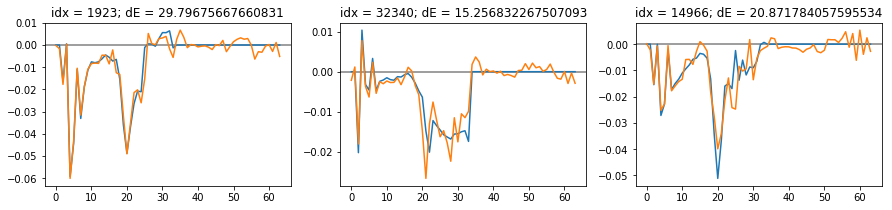

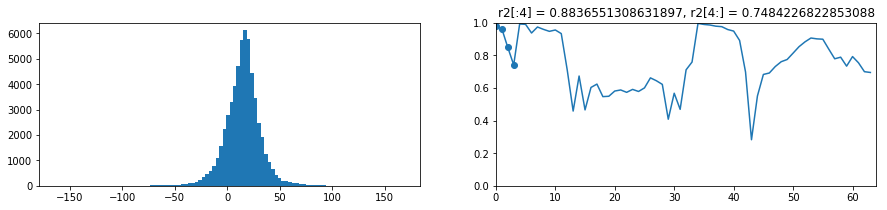

In [111]:
check_preds(net)

### Conservation1 - Culprit variable

#### Post processing

In [38]:
def np_energy_layer_rad(arrs):
    """
    - Inputs: [PS, SOLIN, TAP(z), QAP(z)]
    - Outputs: [FSNT, -FSNS, -FLNT, FLNS, QRL(z), QRS(z)]
    f(eatures) -> 62 layers
    a(ctivations) -> 63 layers
    """
    f, a = arrs
    PS = f[:, 0] * fstds[0] + fmeans[0]
    P = P0 * hyai + PS[:, None] * hybi
    dP = P[:, 1:] - P[:, :-1]
    vintQRL = np.sum(a[:, -60:-30]*dP/G, 1)
    vintQRS = np.sum(a[:, -30:]*dP/G, 1)
    F2to4 = np.sum(a[:, :3], 1) * 1e4
    F1 = (vintQRL + vintQRS - F2to4) / 1e4
    return np.concatenate([np.reshape(F1, (-1, 1)), a], 1)

In [39]:
raw = net.predict(x_val, 4096)

In [46]:
pp = np_energy_layer_rad([x_val, raw[:, 1:]])

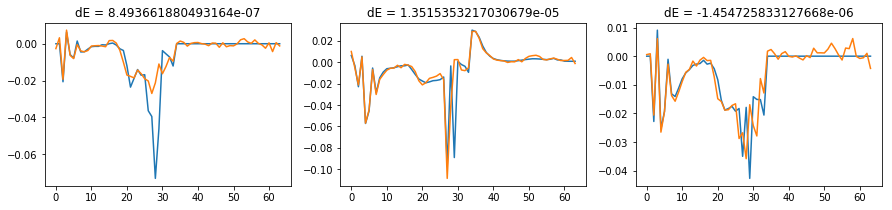

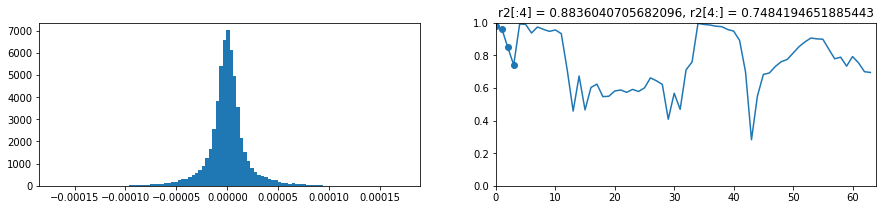

In [87]:
check_preds(None, preds=pp)

#### Now implement into NN

In [48]:
class ConservationLayerRad(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!

    def call(self, arrs):
        """
        - Inputs: [PS, SOLIN, TAP(z), QAP(z)]
        - Outputs: [FSNT, -FSNS, -FLNT, FLNS, QRL(z), QRS(z)]
        f(eatures) -> 62 layers
        a(ctivations) -> 63 layers
        """
        f, a = arrs
        PS = f[:, 0] * fstds[0] + fmeans[0]
        P = P0 * hyai + PS[:, None] * hybi
        dP = P[:, 1:] - P[:, :-1]
        vintQRL = K.sum(a[:, -60:-30]*dP/G, 1)
        vintQRS = K.sum(a[:, -30:]*dP/G, 1)
        F2to4 = K.sum(a[:, :3], 1) * 1e4
        F1 = (vintQRL + vintQRS - F2to4) / 1e4
        return K.concatenate([K.reshape(F1, (-1, 1)), a], 1)

    def compute_output_shape(self, input_shape):
        return (input_shape[1][0], input_shape[1][1]+1)

In [49]:
inp = Input(shape=(62,))
x = LeakyReLU()(Dense(256)(inp))
x = LeakyReLU()(Dense(256)(x))
tmp = Dense(63)(x)
outp = ConservationLayerRad()([inp, tmp])
enet = keras.models.Model(inp, outp)

In [50]:
enet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 62)           0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 256)          16128       input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_3 (LeakyReLU)       (None, 256)          0           dense_4[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 256)          65792       leaky_re_lu_3[0][0]              
__________________________________________________________________________________________________
leaky_re_l

#### Training

In [51]:
enet.compile('adam', 'mse')

In [52]:
enet.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.0031 - val_loss: 4.4031e-04
Epoch 2/10
327680/327680 [==============================] - 4s 13us/step - loss: 3.5669e-04 - val_loss: 2.6943e-04
Epoch 3/10
327680/327680 [==============================] - 4s 13us/step - loss: 2.6091e-04 - val_loss: 2.1479e-04
Epoch 4/10
327680/327680 [==============================] - 4s 13us/step - loss: 2.2274e-04 - val_loss: 1.8803e-04
Epoch 5/10
327680/327680 [==============================] - 4s 13us/step - loss: 2.0147e-04 - val_loss: 1.7183e-04
Epoch 6/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.8738e-04 - val_loss: 1.6153e-04
Epoch 7/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.7773e-04 - val_loss: 1.5300e-04
Epoch 8/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.6932e-04 - val_loss: 1.4842e-04
Epoch 9/10
327680/327680 [=======

In [53]:
enet.optimizer.lr = 1e-4

In [54]:
enet.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.5103e-04 - val_loss: 1.3463e-04
Epoch 2/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.4599e-04 - val_loss: 1.2893e-04
Epoch 3/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.4248e-04 - val_loss: 1.2563e-04
Epoch 4/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.3806e-04 - val_loss: 1.2880e-04
Epoch 5/10
327680/327680 [==============================] - 4s 12us/step - loss: 1.3442e-04 - val_loss: 1.2080e-04
Epoch 6/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.3122e-04 - val_loss: 1.2295e-04
Epoch 7/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.2851e-04 - val_loss: 1.1627e-04
Epoch 8/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.2576e-04 - val_loss: 1.1570e-04
Epoch 9/10
327680/327680 [===

In [55]:
enet.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.1730e-04 - val_loss: 1.1147e-04
Epoch 2/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.1410e-04 - val_loss: 1.0478e-04
Epoch 3/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.1188e-04 - val_loss: 1.1155e-04
Epoch 4/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.0888e-04 - val_loss: 1.0185e-04
Epoch 5/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.0643e-04 - val_loss: 1.0107e-04
Epoch 6/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.0456e-04 - val_loss: 9.7706e-05
Epoch 7/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.0228e-04 - val_loss: 9.5033e-05
Epoch 8/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.0059e-04 - val_loss: 9.5079e-05
Epoch 9/10
327680/327680 [===

In [56]:
enet.optimizer.lr = 1e-5
enet.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 13us/step - loss: 9.5079e-05 - val_loss: 9.5499e-05
Epoch 2/10
327680/327680 [==============================] - 4s 12us/step - loss: 9.3406e-05 - val_loss: 9.0549e-05
Epoch 3/10
327680/327680 [==============================] - 4s 13us/step - loss: 9.2039e-05 - val_loss: 8.9537e-05
Epoch 4/10
327680/327680 [==============================] - 4s 13us/step - loss: 9.0230e-05 - val_loss: 8.6888e-05
Epoch 5/10
327680/327680 [==============================] - 4s 13us/step - loss: 8.9291e-05 - val_loss: 8.8073e-05
Epoch 6/10
327680/327680 [==============================] - 4s 13us/step - loss: 8.7880e-05 - val_loss: 8.6978e-05
Epoch 7/10
327680/327680 [==============================] - 4s 13us/step - loss: 8.6697e-05 - val_loss: 8.2593e-05
Epoch 8/10
327680/327680 [==============================] - 4s 13us/step - loss: 8.5274e-05 - val_loss: 8.5828e-05
Epoch 9/10
327680/327680 [===

In [57]:
enet.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 13us/step - loss: 8.1754e-05 - val_loss: 8.2593e-05
Epoch 2/10
327680/327680 [==============================] - 4s 13us/step - loss: 8.1690e-05 - val_loss: 7.9668e-05
Epoch 3/10
327680/327680 [==============================] - 4s 13us/step - loss: 8.0613e-05 - val_loss: 8.0628e-05
Epoch 4/10
327680/327680 [==============================] - 4s 13us/step - loss: 7.9022e-05 - val_loss: 7.5930e-05
Epoch 5/10
327680/327680 [==============================] - 4s 13us/step - loss: 7.8856e-05 - val_loss: 8.1302e-05
Epoch 6/10
327680/327680 [==============================] - 4s 13us/step - loss: 7.7631e-05 - val_loss: 7.8332e-05
Epoch 7/10
327680/327680 [==============================] - 4s 13us/step - loss: 7.6760e-05 - val_loss: 7.6329e-05
Epoch 8/10
327680/327680 [==============================] - 4s 13us/step - loss: 7.6654e-05 - val_loss: 7.7030e-05
Epoch 9/10
327680/327680 [===

In [58]:
enet.fit(x_trn, y_trn, batch_size=1024, epochs=15, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/15
327680/327680 [==============================] - 4s 13us/step - loss: 7.4081e-05 - val_loss: 7.6402e-05
Epoch 2/15
327680/327680 [==============================] - 4s 13us/step - loss: 7.4158e-05 - val_loss: 7.3229e-05
Epoch 3/15
327680/327680 [==============================] - 4s 13us/step - loss: 7.2967e-05 - val_loss: 7.4029e-05
Epoch 4/15
327680/327680 [==============================] - 4s 13us/step - loss: 7.2520e-05 - val_loss: 7.1516e-05
Epoch 5/15
327680/327680 [==============================] - 4s 13us/step - loss: 7.2106e-05 - val_loss: 7.3439e-05
Epoch 6/15
327680/327680 [==============================] - 4s 13us/step - loss: 7.2240e-05 - val_loss: 7.8350e-05
Epoch 7/15
327680/327680 [==============================] - 4s 13us/step - loss: 7.1493e-05 - val_loss: 7.1040e-05
Epoch 8/15
327680/327680 [==============================] - 4s 13us/step - loss: 7.0284e-05 - val_loss: 7.2794e-05
Epoch 9/15
327680/327680 [===

#### Evaluation

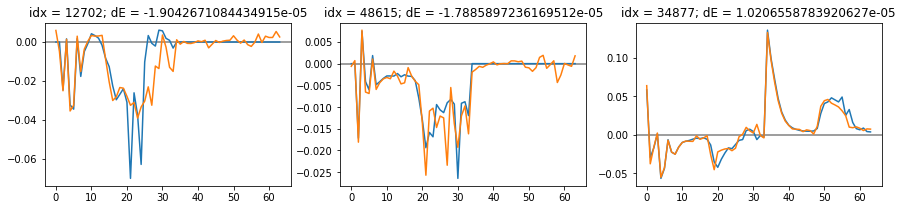

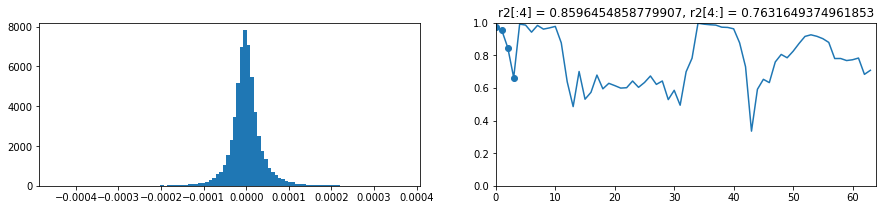

In [112]:
check_preds(enet)

### Version 2: Spread the energy around additively

#### Post-processing

In [122]:
def np_energy_layer_rad2(arrs):
    """
    """
    
    f, a = arrs[0].copy(), arrs[1].copy()
    PS = f[:, 0] * fstds[0] + fmeans[0]
    P = P0 * hyai + PS[:, None] * hybi
    dP = P[:, 1:] - P[:, :-1]
    # Get heating rates per layer in energy units
    eQRL = a[:, -60:-30]*dP/G
    eQRS = a[:, -30:]*dP/G
    vintQRL_abs = np.sum(np.abs(eQRL), 1)
    vintQRS_abs = np.sum(np.abs(eQRS), 1)
    vintQRL = np.sum(eQRL, 1)
    vintQRS = np.sum(eQRS, 1)
    F1to4 = np.sum(a[:, :4], 1) * 1e4
    dE = vintQRL + vintQRS - F1to4
    # Compute correction terms and convert back to heating rates
    #pdb.set_trace()
    tot_abs = vintQRL_abs + vintQRS_abs
    fact = np.abs(eQRL) / tot_abs[:, None]
    #fact = np.where(np.isnan(fact), np.zeros_like(fact), fact)
    QRL_corr = (dE[:, None] * fact) /dP*G
    fact = np.abs(eQRS) / tot_abs[:, None]
    #fact = np.where(np.isnan(fact), np.zeros_like(fact), fact)
    QRS_corr = (dE[:, None] * fact) /dP*G
    a[:, -60:-30] -= QRL_corr
    a[:, -30:] -= QRS_corr

    return a

In [127]:
pp2 = np_energy_layer_rad2([x_val, raw])

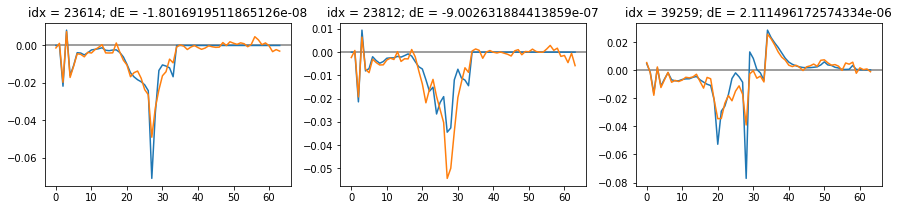

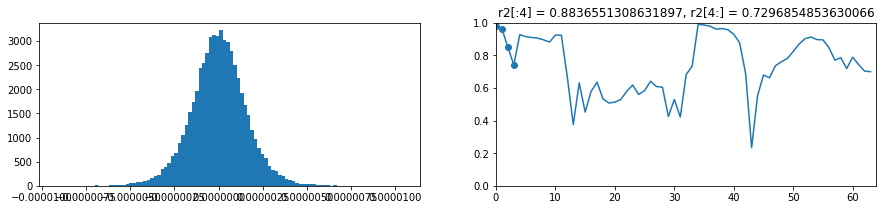

In [128]:
check_preds(None, preds=pp2)

#### Implementation

In [129]:
class ConservationLayerRad2(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!

    def call(self, arrs):
        f, a = arrs
        out = a
        PS = f[:, 0] * fstds[0] + fmeans[0]
        P = P0 * hyai + PS[:, None] * hybi
        dP = P[:, 1:] - P[:, :-1]
        # Get heating rates per layer in energy units
        eQRL = a[:, -60:-30]*dP/G
        eQRS = a[:, -30:]*dP/G        
        vintQRL_abs = K.sum(K.abs(eQRL), 1)
        vintQRS_abs = K.sum(K.abs(eQRS), 1)
        vintQRL = K.sum(eQRL, 1)
        vintQRS = K.sum(eQRS, 1)
        F1to4 = K.sum(a[:, :4], 1) * 1e4
        dE = vintQRL + vintQRS - F1to4
        
        # Compute correction terms and convert back to heating rates
        tot_abs = vintQRL_abs + vintQRS_abs
        
        fact = K.abs(eQRL) / tot_abs[:, None]
        #fact = tf.where(tf.is_nan(fact), K.zeros_like(fact), fact)
        QRL_corr = (dE[:, None] * fact) /dP*G
        fact = K.abs(eQRS) / tot_abs[:, None]
        #fact = tf.where(tf.is_nan(fact), K.zeros_like(fact), fact)
        QRS_corr = (dE[:, None] * fact) /dP*G
        b = a[:, -60:-30] - QRL_corr
        c = a[:, -30:] - QRS_corr

        return K.concatenate([a[:, :4], b, c], 1)

    def compute_output_shape(self, input_shape):
        return input_shape[1]

In [130]:
inp = Input(shape=(62,))
x = LeakyReLU()(Dense(256)(inp))
x = LeakyReLU()(Dense(256)(x))
tmp = Dense(64)(x)
outp = ConservationLayerRad2()([inp, tmp])
enet2 = keras.models.Model(inp, outp)

In [131]:
enet2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 62)           0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 256)          16128       input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 256)          0           dense_10[0][0]                   
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 256)          65792       leaky_re_lu_7[0][0]              
__________________________________________________________________________________________________
leaky_re_l

#### Training

In [132]:
enet2.compile('adam', 'mse')

In [133]:
enet2.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 5s 15us/step - loss: 0.0085 - val_loss: 8.3434e-04
Epoch 2/10
327680/327680 [==============================] - 5s 15us/step - loss: 7.2983e-04 - val_loss: 6.5298e-04
Epoch 3/10
327680/327680 [==============================] - 5s 15us/step - loss: 6.1615e-04 - val_loss: 5.7114e-04
Epoch 4/10
327680/327680 [==============================] - 5s 15us/step - loss: 5.5123e-04 - val_loss: 5.1167e-04
Epoch 5/10
327680/327680 [==============================] - 5s 15us/step - loss: 5.0495e-04 - val_loss: 4.7067e-04
Epoch 6/10
327680/327680 [==============================] - 5s 15us/step - loss: 5.0593e-04 - val_loss: 4.4438e-04
Epoch 7/10
327680/327680 [==============================] - 5s 14us/step - loss: 4.6497e-04 - val_loss: 8.0114e-04
Epoch 8/10
327680/327680 [==============================] - 5s 15us/step - loss: 4.6168e-04 - val_loss: 0.0015
Epoch 9/10
327680/327680 [===========

In [134]:
enet2.optimizer.lr = 1e-4

In [135]:
enet2.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 5s 15us/step - loss: 4.0850e-04 - val_loss: 3.5631e-04
Epoch 2/10
327680/327680 [==============================] - 5s 15us/step - loss: 3.8868e-04 - val_loss: 4.1928e-04
Epoch 3/10
327680/327680 [==============================] - 5s 15us/step - loss: 3.7867e-04 - val_loss: 3.4736e-04
Epoch 4/10
327680/327680 [==============================] - 5s 15us/step - loss: 3.6526e-04 - val_loss: 5.6072e-04
Epoch 5/10
327680/327680 [==============================] - 5s 15us/step - loss: 3.5584e-04 - val_loss: 3.1041e-04
Epoch 6/10
327680/327680 [==============================] - 5s 15us/step - loss: 3.3523e-04 - val_loss: 3.0400e-04
Epoch 7/10
327680/327680 [==============================] - 5s 15us/step - loss: 3.2580e-04 - val_loss: 3.1557e-04
Epoch 8/10
327680/327680 [==============================] - 5s 15us/step - loss: 3.0993e-04 - val_loss: 3.0835e-04
Epoch 9/10
327680/327680 [===

In [136]:
enet2.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 5s 15us/step - loss: 2.3070e-04 - val_loss: 2.0002e-04
Epoch 2/10
327680/327680 [==============================] - 5s 15us/step - loss: 2.1637e-04 - val_loss: 1.8670e-04
Epoch 3/10
327680/327680 [==============================] - 5s 15us/step - loss: 2.0426e-04 - val_loss: 1.8259e-04
Epoch 4/10
327680/327680 [==============================] - 5s 15us/step - loss: 1.9298e-04 - val_loss: 1.6941e-04
Epoch 5/10
327680/327680 [==============================] - 5s 15us/step - loss: 1.7864e-04 - val_loss: 1.5523e-04
Epoch 6/10
327680/327680 [==============================] - 5s 15us/step - loss: 1.6429e-04 - val_loss: 1.4463e-04
Epoch 7/10
327680/327680 [==============================] - 5s 15us/step - loss: 1.5383e-04 - val_loss: 1.4283e-04
Epoch 8/10
327680/327680 [==============================] - 5s 15us/step - loss: 1.4721e-04 - val_loss: 1.3806e-04
Epoch 9/10
327680/327680 [===

In [137]:
enet2.optimizer.lr = 1e-5
enet2.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 5s 15us/step - loss: 1.2806e-04 - val_loss: 1.1839e-04
Epoch 2/10
327680/327680 [==============================] - 5s 15us/step - loss: 1.2375e-04 - val_loss: 1.1458e-04
Epoch 3/10
327680/327680 [==============================] - 5s 15us/step - loss: 1.2091e-04 - val_loss: 1.1093e-04
Epoch 4/10
327680/327680 [==============================] - 5s 15us/step - loss: 1.1569e-04 - val_loss: 1.1084e-04
Epoch 5/10
327680/327680 [==============================] - 5s 15us/step - loss: 1.1224e-04 - val_loss: 1.0505e-04
Epoch 6/10
327680/327680 [==============================] - 5s 15us/step - loss: 1.0899e-04 - val_loss: 1.0510e-04
Epoch 7/10
327680/327680 [==============================] - 5s 15us/step - loss: 1.0624e-04 - val_loss: 1.0093e-04
Epoch 8/10
327680/327680 [==============================] - 5s 15us/step - loss: 1.0404e-04 - val_loss: 1.0210e-04
Epoch 9/10
327680/327680 [===

In [138]:
enet2.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 5s 15us/step - loss: 9.6823e-05 - val_loss: 9.1708e-05
Epoch 2/10
327680/327680 [==============================] - 5s 15us/step - loss: 9.5313e-05 - val_loss: 9.5015e-05
Epoch 3/10
327680/327680 [==============================] - 5s 15us/step - loss: 9.2964e-05 - val_loss: 9.1399e-05
Epoch 4/10
327680/327680 [==============================] - 5s 15us/step - loss: 9.1102e-05 - val_loss: 9.0397e-05
Epoch 5/10
327680/327680 [==============================] - 5s 15us/step - loss: 9.0051e-05 - val_loss: 8.8953e-05
Epoch 6/10
327680/327680 [==============================] - 5s 15us/step - loss: 8.9230e-05 - val_loss: 8.5611e-05
Epoch 7/10
327680/327680 [==============================] - 5s 15us/step - loss: 8.7799e-05 - val_loss: 8.6869e-05
Epoch 8/10
327680/327680 [==============================] - 5s 15us/step - loss: 8.5896e-05 - val_loss: 8.6191e-05
Epoch 9/10
327680/327680 [===

In [139]:
enet2.fit(x_trn, y_trn, batch_size=1024, epochs=15, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/15
327680/327680 [==============================] - 5s 15us/step - loss: 8.2070e-05 - val_loss: 8.0467e-05
Epoch 2/15
327680/327680 [==============================] - 5s 15us/step - loss: 8.1356e-05 - val_loss: 8.1694e-05
Epoch 3/15
327680/327680 [==============================] - 5s 15us/step - loss: 7.9700e-05 - val_loss: 8.1311e-05
Epoch 4/15
327680/327680 [==============================] - 5s 15us/step - loss: 7.9783e-05 - val_loss: 7.9469e-05
Epoch 5/15
327680/327680 [==============================] - 5s 15us/step - loss: 7.8818e-05 - val_loss: 8.2543e-05
Epoch 6/15
327680/327680 [==============================] - 5s 15us/step - loss: 7.7050e-05 - val_loss: 7.9712e-05
Epoch 7/15
327680/327680 [==============================] - 5s 15us/step - loss: 7.7076e-05 - val_loss: 7.6712e-05
Epoch 8/15
327680/327680 [==============================] - 5s 15us/step - loss: 7.6711e-05 - val_loss: 7.8961e-05
Epoch 9/15
327680/327680 [===

#### Evaluation

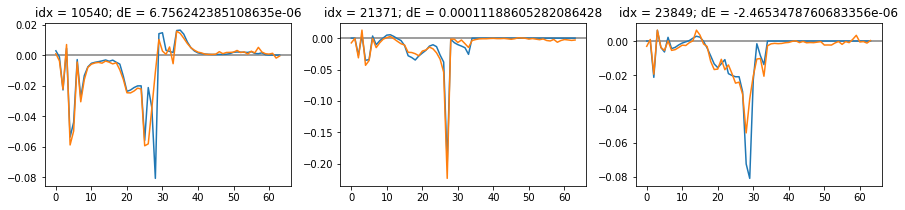

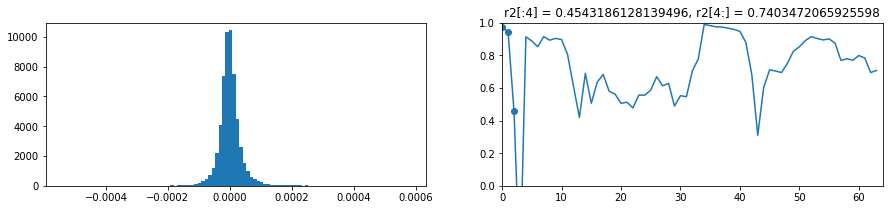

In [144]:
check_preds(enet2)

In [145]:
tmp = enet2.predict(x_val, 4096)

In [146]:
err = tmp - y_val

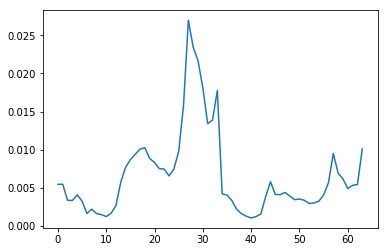

In [148]:
plt.plot(err.std(0))

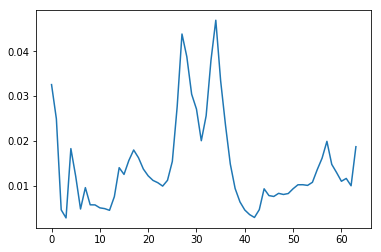

In [149]:
plt.plot(y_val.std(0))

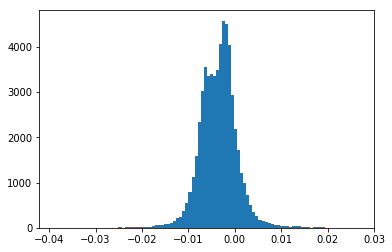

In [151]:
plt.hist(err[:, 4], bins=100);

### Version 3 - Additive correction for all terms

#### Post processing

In [155]:
def np_energy_layer_rad3(arrs):
    """
    """
    
    f, a = arrs[0].copy(), arrs[1].copy()
    PS = f[:, 0] * fstds[0] + fmeans[0]
    P = P0 * hyai + PS[:, None] * hybi
    dP = P[:, 1:] - P[:, :-1]
    # Get heating rates per layer in energy units
    eQRL = a[:, -60:-30]*dP/G
    eQRS = a[:, -30:]*dP/G
    vintQRL_abs = np.sum(np.abs(eQRL), 1)
    vintQRS_abs = np.sum(np.abs(eQRS), 1)
    vintQRL = np.sum(eQRL, 1)
    vintQRS = np.sum(eQRS, 1)
    eF1to4 = a[:, :4]*1e4
    F1to4 = np.sum(eF1to4, 1)
    F1to4_abs = np.sum(np.abs(eF1to4), 1)
    dE = vintQRL + vintQRS - F1to4
    # Compute correction terms and convert back to heating rates
    #pdb.set_trace()
    tot_abs = vintQRL_abs + vintQRS_abs + F1to4_abs
    fact = np.abs(eQRL) / tot_abs[:, None]
    #fact = np.where(np.isnan(fact), np.zeros_like(fact), fact)
    QRL_corr = (dE[:, None] * fact) /dP*G
    fact = np.abs(eQRS) / tot_abs[:, None]
    #fact = np.where(np.isnan(fact), np.zeros_like(fact), fact)
    QRS_corr = (dE[:, None] * fact) /dP*G
    fact = np.abs(eF1to4) / tot_abs[:, None]
    F1to4_corr = (dE[:, None] * fact) / 1e4
    a[:, :4] += F1to4_corr
    a[:, -60:-30] -= QRL_corr
    a[:, -30:] -= QRS_corr

    return a

In [156]:
pp3 = np_energy_layer_rad3([x_val, raw])

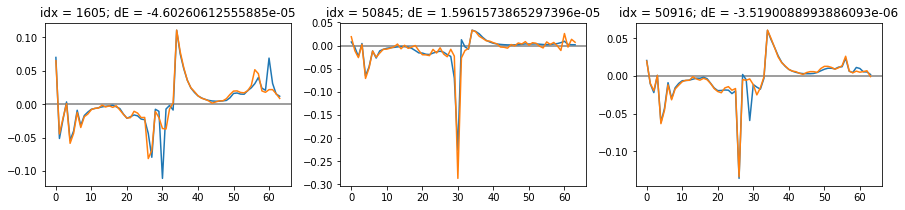

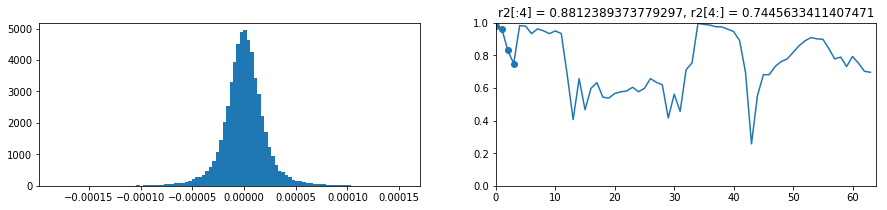

In [157]:
check_preds(None, preds=pp3)

#### Implementation

In [158]:
class ConservationLayerRad3(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!

    def call(self, arrs):
        f, a = arrs
        out = a
        PS = f[:, 0] * fstds[0] + fmeans[0]
        P = P0 * hyai + PS[:, None] * hybi
        dP = P[:, 1:] - P[:, :-1]
        # Get heating rates per layer in energy units
        eQRL = a[:, -60:-30]*dP/G
        eQRS = a[:, -30:]*dP/G        
        vintQRL_abs = K.sum(K.abs(eQRL), 1)
        vintQRS_abs = K.sum(K.abs(eQRS), 1)
        vintQRL = K.sum(eQRL, 1)
        vintQRS = K.sum(eQRS, 1)
        eF1to4 = a[:, :4]*1e4
        F1to4 = K.sum(eF1to4, 1)
        F1to4_abs = K.sum(K.abs(eF1to4), 1)
        dE = vintQRL + vintQRS - F1to4
        
        # Compute correction terms and convert back to heating rates
        tot_abs = vintQRL_abs + vintQRS_abs + F1to4_abs
        
        fact = K.abs(eQRL) / tot_abs[:, None]
        #fact = tf.where(tf.is_nan(fact), K.zeros_like(fact), fact)
        QRL_corr = (dE[:, None] * fact) /dP*G
        fact = K.abs(eQRS) / tot_abs[:, None]
        #fact = tf.where(tf.is_nan(fact), K.zeros_like(fact), fact)
        QRS_corr = (dE[:, None] * fact) /dP*G
        fact = K.abs(eF1to4) / tot_abs[:, None]
        F1to4_corr = (dE[:, None] * fact) / 1e4
        all_corr = K.concatenate([F1to4_corr, -QRL_corr, -QRS_corr])
        out = a + all_corr

        return out

    def compute_output_shape(self, input_shape):
        return input_shape[1]

In [159]:
inp = Input(shape=(62,))
x = LeakyReLU()(Dense(256)(inp))
x = LeakyReLU()(Dense(256)(x))
tmp = Dense(64)(x)
outp = ConservationLayerRad3()([inp, tmp])
enet3 = keras.models.Model(inp, outp)

In [160]:
enet3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 62)           0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 256)          16128       input_5[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 256)          0           dense_13[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 256)          65792       leaky_re_lu_9[0][0]              
__________________________________________________________________________________________________
leaky_re_l

#### Training

In [161]:
enet3.compile('adam', 'mse')

In [162]:
enet3.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 5s 16us/step - loss: 0.0029 - val_loss: 5.8302e-04
Epoch 2/10
327680/327680 [==============================] - 5s 16us/step - loss: 5.9837e-04 - val_loss: 5.5973e-04
Epoch 3/10
327680/327680 [==============================] - 5s 16us/step - loss: 5.7693e-04 - val_loss: 5.3759e-04
Epoch 4/10
327680/327680 [==============================] - 5s 16us/step - loss: 5.6191e-04 - val_loss: 5.2924e-04
Epoch 5/10
327680/327680 [==============================] - 5s 17us/step - loss: 5.5384e-04 - val_loss: 5.2229e-04
Epoch 6/10
327680/327680 [==============================] - 5s 17us/step - loss: 5.4405e-04 - val_loss: 5.2084e-04
Epoch 7/10
327680/327680 [==============================] - 5s 17us/step - loss: 5.4089e-04 - val_loss: 5.1264e-04
Epoch 8/10
327680/327680 [==============================] - 5s 17us/step - loss: 5.3483e-04 - val_loss: 5.1964e-04
Epoch 9/10
327680/327680 [=======

In [163]:
enet3.optimizer.lr = 1e-4

In [164]:
enet3.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 5s 16us/step - loss: 5.0794e-04 - val_loss: 4.9143e-04
Epoch 2/10
327680/327680 [==============================] - 5s 16us/step - loss: 4.9404e-04 - val_loss: 4.4500e-04
Epoch 3/10
327680/327680 [==============================] - 5s 16us/step - loss: 4.0693e-04 - val_loss: 3.5342e-04
Epoch 4/10
327680/327680 [==============================] - 5s 16us/step - loss: 2.9503e-04 - val_loss: 2.3733e-04
Epoch 5/10
327680/327680 [==============================] - 5s 16us/step - loss: 2.3309e-04 - val_loss: 2.0235e-04
Epoch 6/10
327680/327680 [==============================] - 5s 16us/step - loss: 1.9588e-04 - val_loss: 1.7564e-04
Epoch 7/10
327680/327680 [==============================] - 5s 16us/step - loss: 1.7827e-04 - val_loss: 1.5693e-04
Epoch 8/10
327680/327680 [==============================] - 5s 16us/step - loss: 1.6282e-04 - val_loss: 1.4788e-04
Epoch 9/10
327680/327680 [===

In [165]:
enet3.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 5s 16us/step - loss: 1.3309e-04 - val_loss: 1.1995e-04
Epoch 2/10
327680/327680 [==============================] - 5s 16us/step - loss: 1.2835e-04 - val_loss: 1.1866e-04
Epoch 3/10
327680/327680 [==============================] - 5s 15us/step - loss: 1.2197e-04 - val_loss: 1.1549e-04
Epoch 4/10
327680/327680 [==============================] - 5s 16us/step - loss: 1.1837e-04 - val_loss: 1.0984e-04
Epoch 5/10
327680/327680 [==============================] - 5s 16us/step - loss: 1.1483e-04 - val_loss: 1.0649e-04
Epoch 6/10
327680/327680 [==============================] - 5s 15us/step - loss: 1.1162e-04 - val_loss: 1.0305e-04
Epoch 7/10
327680/327680 [==============================] - 5s 16us/step - loss: 1.0837e-04 - val_loss: 1.0409e-04
Epoch 8/10
327680/327680 [==============================] - 5s 16us/step - loss: 1.0612e-04 - val_loss: 9.7480e-05
Epoch 9/10
327680/327680 [===

In [167]:
enet3.optimizer.lr = 1e-5
enet3.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 5s 16us/step - loss: 9.8305e-05 - val_loss: 9.3917e-05
Epoch 2/10
327680/327680 [==============================] - 5s 16us/step - loss: 9.5507e-05 - val_loss: 8.9833e-05
Epoch 3/10
327680/327680 [==============================] - 5s 16us/step - loss: 9.3664e-05 - val_loss: 9.2235e-05
Epoch 4/10
327680/327680 [==============================] - 5s 16us/step - loss: 9.2371e-05 - val_loss: 8.6609e-05
Epoch 5/10
327680/327680 [==============================] - 5s 16us/step - loss: 9.0109e-05 - val_loss: 8.5936e-05
Epoch 6/10
327680/327680 [==============================] - 5s 16us/step - loss: 8.8731e-05 - val_loss: 8.4096e-05
Epoch 7/10
327680/327680 [==============================] - 5s 16us/step - loss: 8.6298e-05 - val_loss: 8.6252e-05
Epoch 8/10
327680/327680 [==============================] - 4s 13us/step - loss: 8.5038e-05 - val_loss: 8.1594e-05
Epoch 9/10
327680/327680 [===

In [168]:
enet3.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 5s 16us/step - loss: 8.1807e-05 - val_loss: 8.0774e-05
Epoch 2/10
327680/327680 [==============================] - 5s 16us/step - loss: 7.9810e-05 - val_loss: 8.0750e-05
Epoch 3/10
327680/327680 [==============================] - 5s 16us/step - loss: 7.9718e-05 - val_loss: 7.7533e-05
Epoch 4/10
327680/327680 [==============================] - 5s 16us/step - loss: 7.9416e-05 - val_loss: 8.1535e-05
Epoch 5/10
327680/327680 [==============================] - 5s 16us/step - loss: 7.7578e-05 - val_loss: 7.5621e-05
Epoch 6/10
327680/327680 [==============================] - 5s 16us/step - loss: 7.6707e-05 - val_loss: 7.5032e-05
Epoch 7/10
327680/327680 [==============================] - 5s 16us/step - loss: 7.5843e-05 - val_loss: 7.4894e-05
Epoch 8/10
327680/327680 [==============================] - 5s 16us/step - loss: 7.5077e-05 - val_loss: 7.6442e-05
Epoch 9/10
327680/327680 [===

In [169]:
enet3.fit(x_trn, y_trn, batch_size=1024, epochs=15, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/15
327680/327680 [==============================] - 5s 16us/step - loss: 7.2968e-05 - val_loss: 7.4187e-05
Epoch 2/15
327680/327680 [==============================] - 5s 16us/step - loss: 7.2999e-05 - val_loss: 7.4139e-05
Epoch 3/15
327680/327680 [==============================] - 5s 16us/step - loss: 7.1677e-05 - val_loss: 7.7792e-05
Epoch 4/15
327680/327680 [==============================] - 5s 16us/step - loss: 7.1589e-05 - val_loss: 7.2783e-05
Epoch 5/15
327680/327680 [==============================] - 5s 16us/step - loss: 7.1426e-05 - val_loss: 7.2422e-05
Epoch 6/15
327680/327680 [==============================] - 5s 16us/step - loss: 7.0201e-05 - val_loss: 6.9743e-05
Epoch 7/15
327680/327680 [==============================] - 5s 16us/step - loss: 7.0230e-05 - val_loss: 7.2207e-05
Epoch 8/15
327680/327680 [==============================] - 5s 16us/step - loss: 6.9307e-05 - val_loss: 7.3313e-05
Epoch 9/15
327680/327680 [===

#### Evaluation

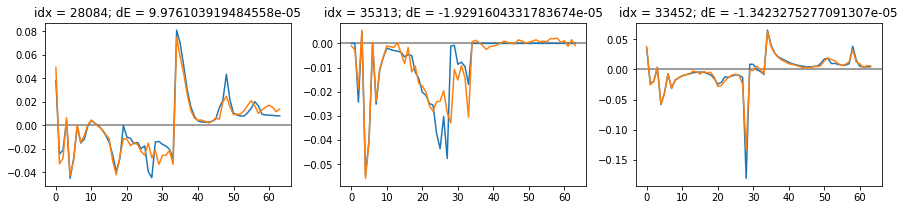

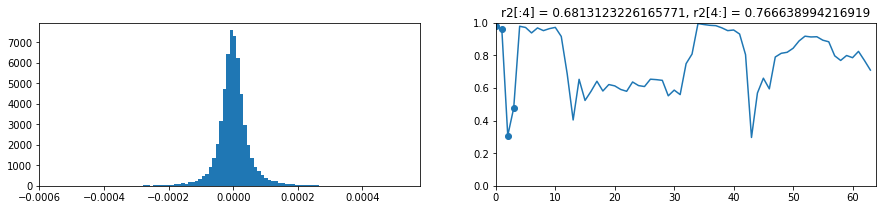

In [170]:
check_preds(enet3)

### Version 4 - spread multiplicatively -- OUT OF DATE I DONT THINK THIS ACTUALLY WORKS

#### Post-processing

In [108]:
def np_energy_layer_rad3(arrs):
    """
    """
    pdb.set_trace()
    f, a = arrs[0].copy(), arrs[1].copy()
    PS = f[:, 0] * fstds[0] + fmeans[0]
    P = P0 * hyai + PS[:, None] * hybi
    dP = P[:, 1:] - P[:, :-1]
    # Get heating rates per layer in energy units
    eQRL = a[:, -60:-30]*dP/G
    eQRS = a[:, -30:]*dP/G
    vintQRL_abs = np.sum(np.abs(eQRL), 1)
    vintQRS_abs = np.sum(np.abs(eQRS), 1)
    vintQRL = np.sum(eQRL, 1)
    vintQRS = np.sum(eQRS, 1)
    F1to4 = np.sum(a[:, :4], 1) * 1e4
    dE = vintQRL + vintQRS - F1to4
    # Compute correction terms and convert back to heating rates

    totvint = vintQRL + vintQRS
    fact = F1to4 / totvint
    a[:, -60:] *= fact[:, None]
    
    return a

In [109]:
pp3 = np_energy_layer_rad3([x_val, raw])

> <ipython-input-108-eb734d2612bf>(5)np_energy_layer_rad3()
-> f, a = arrs[0].copy(), arrs[1].copy()
(Pdb) n
> <ipython-input-108-eb734d2612bf>(6)np_energy_layer_rad3()
-> PS = f[:, 0] * fstds[0] + fmeans[0]
(Pdb) n
> <ipython-input-108-eb734d2612bf>(7)np_energy_layer_rad3()
-> P = P0 * hyai + PS[:, None] * hybi
(Pdb) n
> <ipython-input-108-eb734d2612bf>(8)np_energy_layer_rad3()
-> dP = P[:, 1:] - P[:, :-1]
(Pdb) n
> <ipython-input-108-eb734d2612bf>(10)np_energy_layer_rad3()
-> eQRL = a[:, -60:-30]*dP/G
(Pdb) n
> <ipython-input-108-eb734d2612bf>(11)np_energy_layer_rad3()
-> eQRS = a[:, -30:]*dP/G
(Pdb) n
> <ipython-input-108-eb734d2612bf>(12)np_energy_layer_rad3()
-> vintQRL_abs = np.sum(np.abs(eQRL), 1)
(Pdb) n
> <ipython-input-108-eb734d2612bf>(13)np_energy_layer_rad3()
-> vintQRS_abs = np.sum(np.abs(eQRS), 1)
(Pdb) n
> <ipython-input-108-eb734d2612bf>(14)np_energy_layer_rad3()
-> vintQRL = np.sum(eQRL, 1)
(Pdb) n
> <ipython-input-108-eb734d2612bf>(15)np_energy_layer_rad3()
-> vintQR

BdbQuit: 

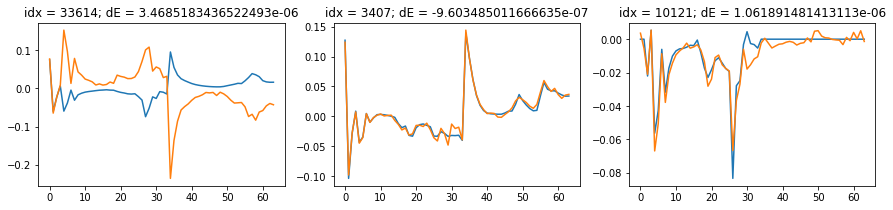

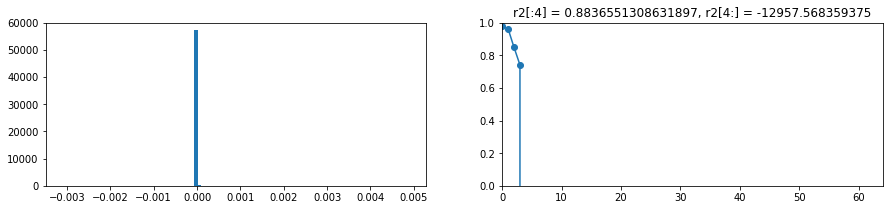

In [106]:
check_preds(None, preds=pp3)

#### Implementation

In [159]:
class ConservationLayerRad3(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!

    def call(self, arrs):
        f, a = arrs
        PS = f[:, 0] * fstds[0] + fmeans[0]
        P = P0 * hyai + PS[:, None] * hybi
        dP = P[:, 1:] - P[:, :-1]
        # Get heating rates per layer in energy units
        eQRL = a[:, -60:-30]*dP/G
        eQRS = a[:, -30:]*dP/G
        vintQRL_abs = K.sum(K.abs(eQRL), 1)
        vintQRS_abs = K.sum(K.abs(eQRS), 1)
        vintQRL = K.sum(eQRL, 1)
        vintQRS = K.sum(eQRS, 1)
        F1to4 = K.sum(a[:, :4], 1) * 1e4
        dE = vintQRL + vintQRS - F1to4

        totvint = vintQRL + vintQRS
        fact = F1to4 / totvint
        out = a[:, -60:] * fact[:, None]

        return K.concatenate([a[:, :4], out], 1)

    def compute_output_shape(self, input_shape):
        return input_shape[1]

In [160]:
inp = Input(shape=(62,))
x = LeakyReLU()(Dense(256)(inp))
x = LeakyReLU()(Dense(256)(x))
tmp = Dense(64)(x)
outp = ConservationLayerRad3()([inp, tmp])
enet3 = keras.models.Model(inp, outp)

In [161]:
enet3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 62)           0                                            
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 256)          16128       input_14[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_15 (LeakyReLU)      (None, 256)          0           dense_22[0][0]                   
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 256)          65792       leaky_re_lu_15[0][0]             
__________________________________________________________________________________________________
leaky_re_l

In [162]:
enet3.compile('adam', 'mse')

In [179]:
enet.optimizer.lr=1e-6

In [180]:
enet3.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.2933 - val_loss: 0.1809
Epoch 2/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.2670 - val_loss: 0.1633
Epoch 3/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.2425 - val_loss: 0.1508
Epoch 4/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.2229 - val_loss: 0.1404
Epoch 5/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.2019 - val_loss: 0.1304
Epoch 6/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.1852 - val_loss: 0.1246
Epoch 7/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.1717 - val_loss: 0.1190
Epoch 8/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.1557 - val_loss: 0.1163
Epoch 9/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.5408 - val

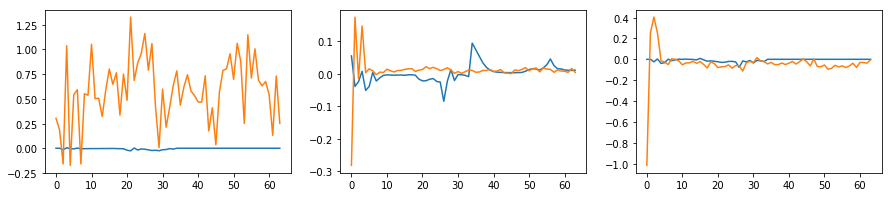

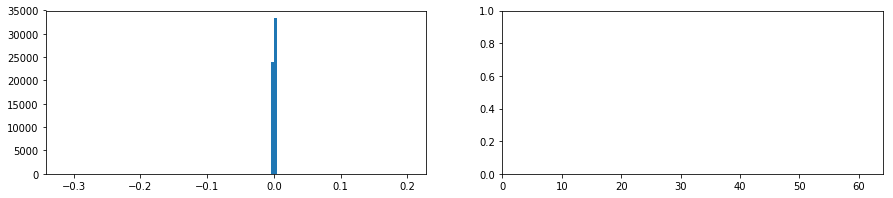

In [181]:
check_preds(enet3)